# Business Case: AdEase Time Series
 
# Defining Problem Statement & Data Import

### Problem Statement: 
Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.
You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

### Dataset:
https://drive.google.com/drive/folders/1mdgQscjqnCtdg7LGItomyK0abN6lcHBb

### Data Dictionary:
There are two csv files given
   - **train_1.csv:** In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.

The page name contains data in this format:
SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN
having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)
   - **Exog_Campaign_eng:** This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

There’s 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English
Concepts Tested:
   * Exploratory data analysis
   * Time Series forecasting- ARIMA, SARIMAX, and Prophet
   
# Analysing basic metrics

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings # supress warnings
warnings.filterwarnings('ignore')

## Importing Data & removing non-relevant columns / duplicates

In [2]:
df = pd.read_csv('../Scaler/train_1.csv')
Exog_Campaign_eng = pd.read_csv('../Scaler/Exog_Campaign_eng')

In [3]:
#creating copy of dataframe for backup
data = df.copy(deep = True)
data.drop_duplicates(keep='last', inplace = True)

In [4]:
print(f'Shape of Data : {data.shape}')
print('-'*80)
print(f'Shape of exogenous variable : {Exog_Campaign_eng.shape}')

Shape of Data : (145063, 551)
--------------------------------------------------------------------------------
Shape of exogenous variable : (550, 1)


In [5]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


 * Data for 550 Dates (1.5 Years / 18 Months) is provided for all pages

In [6]:
data.dtypes

Page           object
2015-07-01    float64
2015-07-02    float64
2015-07-03    float64
2015-07-04    float64
               ...   
2016-12-27    float64
2016-12-28    float64
2016-12-29    float64
2016-12-30    float64
2016-12-31    float64
Length: 551, dtype: object

### significance of Null Values

In [7]:
#Checking count of Null Values after every 25th Column in Data
data.isnull().sum()[range(1,550,25)]

2015-07-01    20740
2015-07-26    19865
2015-08-20    18923
2015-09-14    18407
2015-10-09    17771
2015-11-03    15734
2015-11-28    15847
2015-12-23    14647
2016-01-17    13667
2016-02-11    12057
2016-03-07    11485
2016-04-01    10385
2016-04-26     9679
2016-05-21     9216
2016-06-15     8071
2016-07-10     7836
2016-08-04     6917
2016-08-29     6022
2016-09-23     5457
2016-10-18     4858
2016-11-12     4234
2016-12-07     4130
dtype: int64

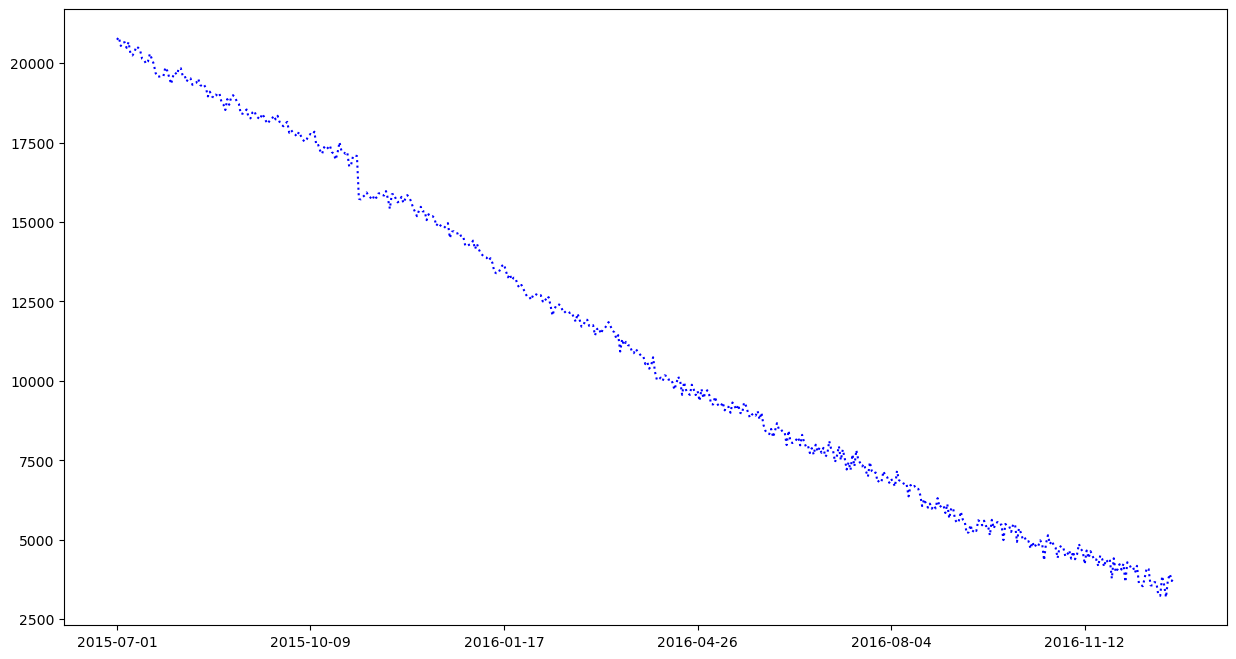

In [8]:
#Visualizing Null-values count for all columns
plt.figure(figsize=(15, 8))
data.iloc[:, 1:-3 ].isnull().sum().plot(color='blue', linestyle='dotted')
plt.show()

* Above Plot indicates that NaN / Null values are decreasing with Time. Later Dates have less Null Values as compared to Older Dates.
* recent dates have lesser null values that means newer pages will have no data of prior to that page hosting date.
* We will drop the rows where more than 300 null values are present and replace remaining Null Values with 0.

In [9]:
data.dropna(thresh = 300, inplace = True)
print(f'Shape of Data : {data.shape}')

Shape of Data : (133617, 551)


In [10]:
data.fillna(0, inplace = True)

In [11]:
#Checking count of Null Values after every 25th Column in Data
data.isnull().sum()[range(1,550,25)]

2015-07-01    0
2015-07-26    0
2015-08-20    0
2015-09-14    0
2015-10-09    0
2015-11-03    0
2015-11-28    0
2015-12-23    0
2016-01-17    0
2016-02-11    0
2016-03-07    0
2016-04-01    0
2016-04-26    0
2016-05-21    0
2016-06-15    0
2016-07-10    0
2016-08-04    0
2016-08-29    0
2016-09-23    0
2016-10-18    0
2016-11-12    0
2016-12-07    0
dtype: int64

## Exploratory Data Analysis & Feature Engineering
### Extracting Language , access type and access origin from page

In [12]:
# Extracting Language from page
data.Page[0]

'2NE1_zh.wikipedia.org_all-access_spider'

In [13]:
import re
re.findall(r'_(.{2}).wikipedia.org_', "2NE1_zh.wikipedia.org_all-access_spider")

['zh']

In [14]:
data.Page.str.findall(pat="_(.{2}).wikipedia.org_").sample(10)

59454     [ja]
4528      [fr]
2199      [zh]
36112     [en]
140509    [de]
112307    [en]
120846    [ja]
100385    [ru]
63316     [zh]
22230       []
Name: Page, dtype: object

In [15]:
#Function to Extract Language from Page using Regex
def get_language(name):
    if len(re.findall(r'_(.{2}).wikipedia.org_', name)) == 1 : 
        return re.findall(r'_(.{2}).wikipedia.org_', name)[0]
    else: return 'Unknown'

In [16]:
data['language'] = data['Page'].apply(get_language)

In [17]:
data["language"].unique()

array(['zh', 'fr', 'en', 'Unknown', 'ru', 'de', 'ja', 'es'], dtype=object)

In [18]:
language_dict ={'de':'German',
                'en':'English', 
                'es': 'Spanish', 
                'fr': 'French', 
                'ja': 'Japenese' , 
                'ru': 'Russian', 
                'zh': 'Chinese',
                'Unknown': 'Unknown_language'}

data['language'] = data['language'].map(language_dict)

In [19]:
data["language"].unique()

array(['Chinese', 'French', 'English', 'Unknown_language', 'Russian',
       'German', 'Japenese', 'Spanish'], dtype=object)

In [20]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,language
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,Chinese
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,Chinese
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,Chinese
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,Chinese
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0,Chinese


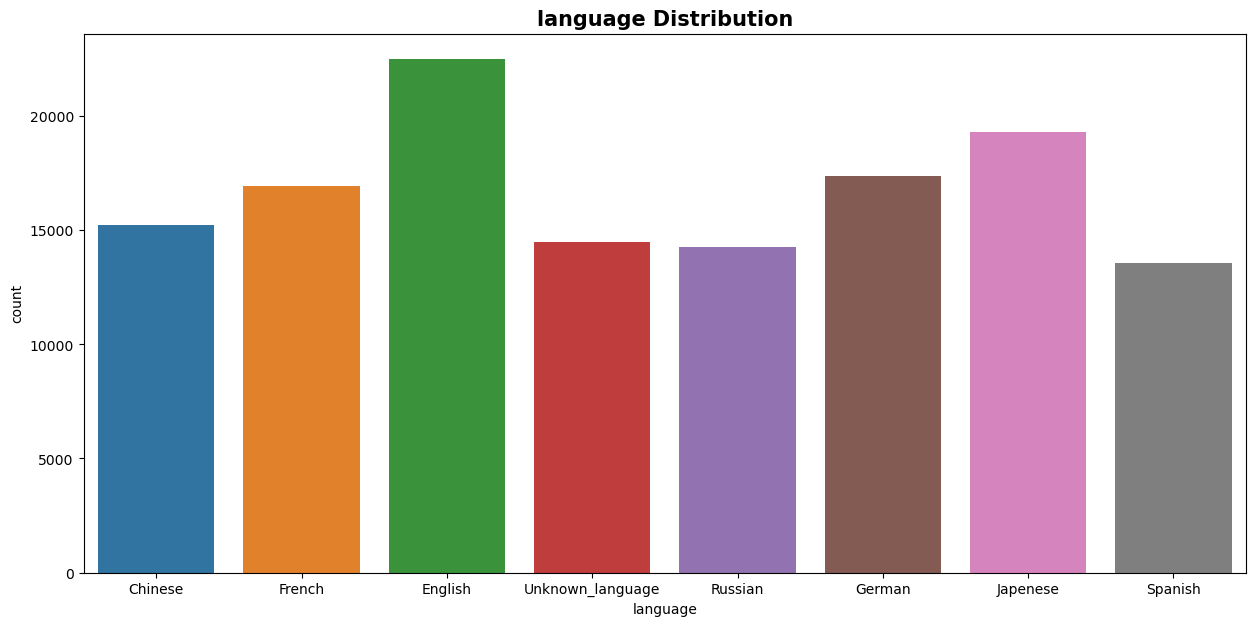

In [21]:
#Visualizing distribution of various languages
y = 'language'

plt.figure(figsize=(15, 7))
sns.countplot(x=data['language'] , data=data)
plt.title(f' {y} Distribution')
plt.xlabel(f'{y}')
plt.ylabel('count')
plt.title(f'{y} Distribution', fontsize = 15, fontweight = 'bold')
plt.show()

In [22]:
# unique value Language column(listed in %)
Language = data["language"].value_counts(normalize=True).map(lambda calc: round(100*calc,2)).reset_index()
Language.columns = ['Language', 'Count']
Language

,Language,Count
0,English,16.83
1,Japenese,14.44
2,German,12.99
3,French,12.68
4,Chinese,11.38
5,Unknown_language,10.85
6,Russian,10.68
7,Spanish,10.14


* 10.85% of pages have unknown language.
* 16.83% of all pages are in English which is highest.

In [23]:
data.loc[data['language'] == 'Unknown_language', 'Page'].sample(100).head(10)

42918    Topic:Rlqs29fxd74rxtpo_www.mediawiki.org_deskt...
14376    File:Seal_of_the_President_of_the_United_State...
23209    API:Errors_and_warnings_www.mediawiki.org_mobi...
13795    Category:Vintage_photographs_of_nude_males_com...
45264    Category:Nude_girls_commons.wikimedia.org_all-...
45610    File:Olympic_rings_without_rims.svg_commons.wi...
21633    Help:Contents/he_www.mediawiki.org_mobile-web_...
45789    Category:Bollywood_films_commons.wikimedia.org...
44881    File:Speaker_Icon.svg_commons.wikimedia.org_al...
15740    File:English_Pokémon_logo.svg_commons.wikimedi...
Name: Page, dtype: object

 * Around 10.85% of rows (~14k) don't have Language information

In [24]:
#Function to Extract Access Type from Page using Regex
def get_access_type(name):
    if len(re.findall(r'all-access|mobile-web|desktop', name)) == 1 : 
        return re.findall(r'all-access|mobile-web|desktop', name)[0]
    else: return 'No Access_type'

data['Access_type'] = data['Page'].apply(get_access_type)

In [25]:
# unique value Access_Type column(listed in %)
Access_type = data["Access_type"].value_counts(normalize=True).map(lambda calc: round(100*calc,2)).reset_index()
Access_type.columns = ['Access_type', 'Count']
Access_type

,Access_type,Count
0,all-access,51.43
1,mobile-web,24.92
2,desktop,23.65


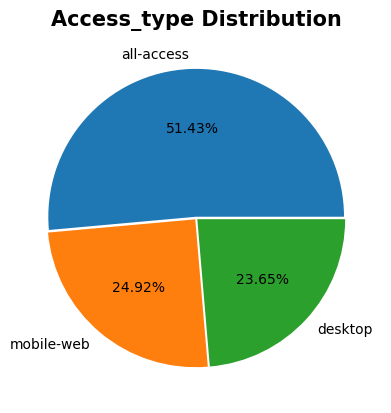

In [26]:
#Visualizing Access types Distribution
var = 'Access_type'
x = data[var].value_counts().values
y = data[var].value_counts().index

plt.pie(x, labels = y, autopct='%.2f%%',  explode = [0.01,0.01,0.01])
plt.title(f'{var} Distribution', fontsize = 15, fontweight = 'bold')
plt.show()

In [27]:
#Function to Extract Access Origin from Page using Regex
def get_access_origin(name):
    if len(re.findall(r'[ai].org_(.*)_(.*)$', name)) == 1 : 
        return re.findall(r'[ai].org_(.*)_(.*)$', name)[0][1]
    else: return 'No Access_origin'
    
data['Access_origin'] = data['Page'].apply(get_access_origin)

In [28]:
# unique value Access_origin column(listed in %)
Access_origin = data["Access_origin"].value_counts(normalize=True).map(lambda calc: round(100*calc,2)).reset_index()
Access_origin.columns = ['Access_origin', 'Count']
Access_origin

,Access_origin,Count
0,all-agents,75.82
1,spider,24.18


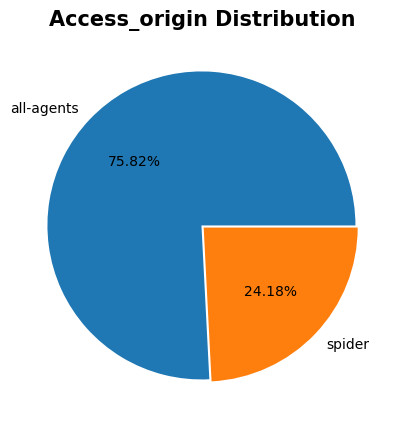

In [29]:
#Visualizing Access types Distribution
var = 'Access_origin'
x = data[var].value_counts().values
y = data[var].value_counts().index

plt.figure(figsize=(6, 5))
plt.pie(x, labels = y, autopct='%.2f%%',  explode = [0.01,0.01])
plt.title(f'{var} Distribution', fontsize = 15, fontweight = 'bold')
plt.show()

## Data Pre-processing
### mean page visit per language 

In [30]:
data_language = pd.DataFrame()
data_language = data.groupby('language').mean().transpose()
data_language.drop(['Unknown_language'], inplace = True, axis = 1)
data_language.reset_index(inplace = True)
data_language.set_index('index', inplace = True)
data_language.head()

language,Chinese,English,French,German,Japenese,Russian,Spanish
index,,,,,,,
2015-07-01,272.498521,3767.328604,499.092872,763.765926,614.637160,663.199229,1127.485204
2015-07-02,272.906778,3755.158765,502.297852,753.362861,705.813216,674.677015,1077.485425
2015-07-03,271.097167,3565.225696,483.007553,723.074415,637.451671,625.329783,990.895949
2015-07-04,273.712379,3711.782932,516.275785,663.537323,800.897435,588.171829,930.303151
2015-07-05,291.977713,3833.433025,506.871666,771.358657,768.352319,626.385354,1011.759575


In [31]:
data_language.info()

<class 'pandas.core.frame.DataFrame'>
Index: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Chinese   550 non-null    float64
 1   English   550 non-null    float64
 2   French    550 non-null    float64
 3   German    550 non-null    float64
 4   Japenese  550 non-null    float64
 5   Russian   550 non-null    float64
 6   Spanish   550 non-null    float64
dtypes: float64(7)
memory usage: 34.4+ KB


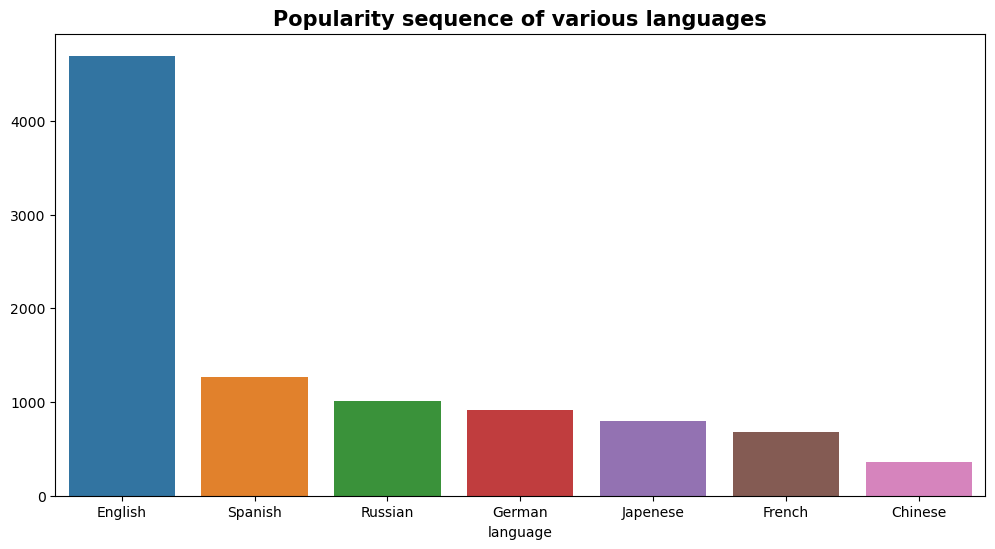

In [32]:
x = data_language.mean().sort_values(ascending = False).index
y = data_language.mean().sort_values(ascending = False).values

plt.figure(figsize=(12, 6))
sns.barplot(x = x,y =y)
plt.title(f'Popularity sequence of various languages', fontsize = 15, fontweight = 'bold')
plt.show()

## Popularity sequence of various languages : English > Spanish > Russian > German > Japenese > French > Chinese

### Visualising Time Series for each languages

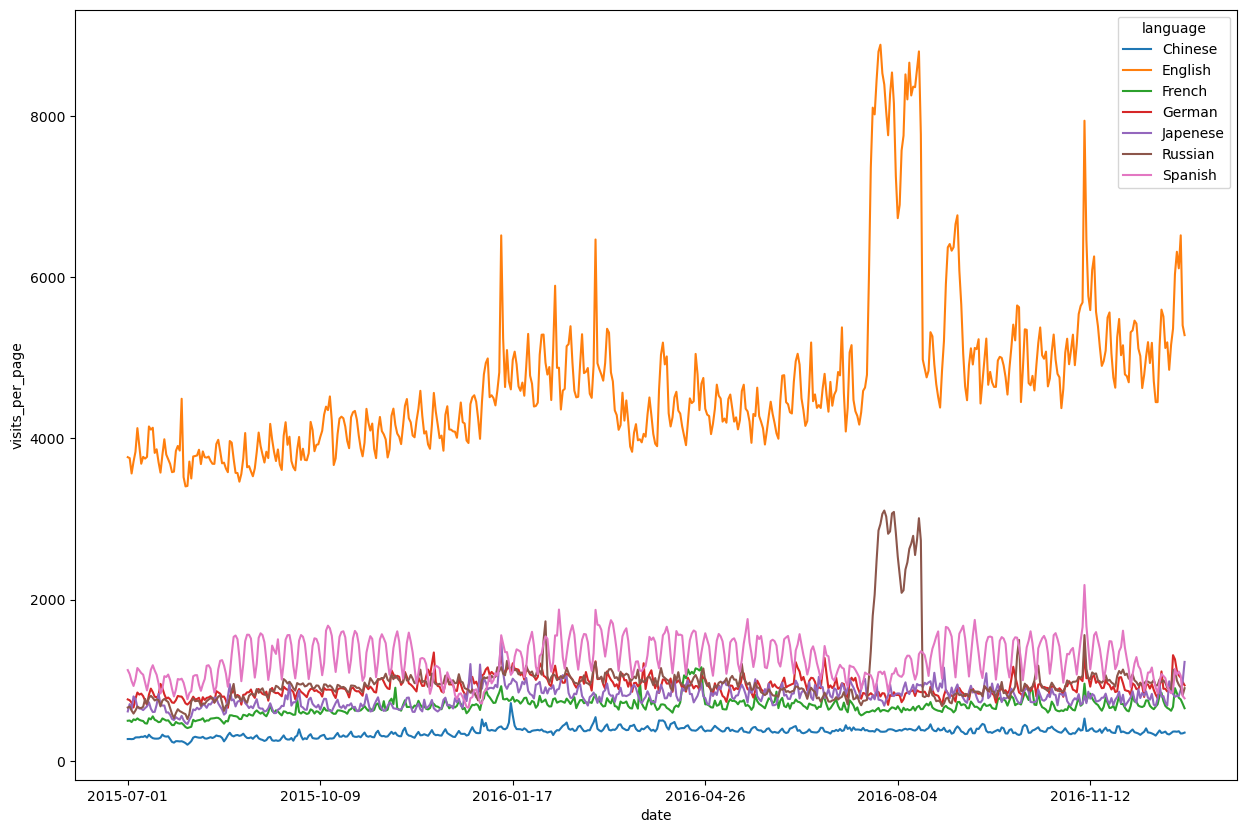

In [33]:
data_language.plot(label = data_language.columns,  figsize=(15, 10))
plt.xlabel("date")
plt.ylabel("visits_per_page")
plt.show()

# Hypothesis Testing : if Time Series is Stationary or Trending using ADF (Augmented Dickey Fuller) Test:
* Null Hypothesis: The series is Non-Stationary

* Alternative Hypothesis: The series is Stationary

* significant value : 0.05 (alpha)

* if p-value > 0.05 : we failed to reject Null hypothesis:

    * That means the series is Non-Stationart
* if p-value <= 0.05: we reject Null Hypothesis

    * that means the time series in Stationary

In [35]:
import statsmodels.api as sm
def Dickey_Fuller_test(ts,significances_level = 0.05):
    p_value = sm.tsa.stattools.adfuller(ts)[1]
    if p_value <= significances_level:
        print("Time Series is Stationary")
    else:
        print("Time Series is NOT Stationary")
    print("P_value is: ", p_value)

In [36]:
for Language in data_language.columns:
  print(Language)
  print(Dickey_Fuller_test(data_language[Language],significances_level = 0.05))
  print()
  print()

Chinese
Time Series is NOT Stationary
P_value is:  0.3219384419565085
None


English
Time Series is NOT Stationary
P_value is:  0.14933749437355304
None


French
Time Series is Stationary
P_value is:  0.04296020201712812
None


German
Time Series is NOT Stationary
P_value is:  0.1400503200836024
None


Japenese
Time Series is NOT Stationary
P_value is:  0.07231258891845853
None


Russian
Time Series is Stationary
P_value is:  0.0017632662037633297
None


Spanish
Time Series is Stationary
P_value is:  0.04215053463615071
None




* Based on DickeyFuller test of Stationarity , we can observe French, Spanish and Russian languages Pages visits Time series are stationary.
* Chinese, English , German and Japanese are not stationary.

In [37]:
# Further analysing Time Series for English Language Pages Visits : 
TS_English = data_language.English

In [38]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
       df_output['Critical Value (%s)' %key] = value
    print (df_output)

In [39]:
#apply adf test on the series
adf_test(TS_English)

Results of Dickey-Fuller Test:
Test Statistic                  -2.373563
p-value                          0.149337
#Lags Used                      14.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.442632
Critical Value (5%)             -2.866957
Critical Value (10%)            -2.569655
dtype: float64


* The test statistic > critical value / p_value > 5%.
* This implies that the series is not stationary.

## Visualising English-Language Page Visits Time Series manually to identify seasonality and period

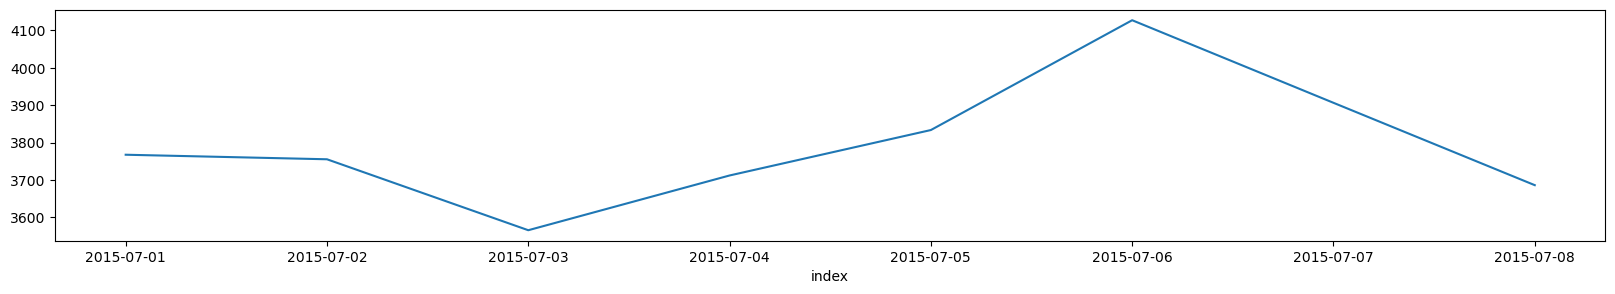

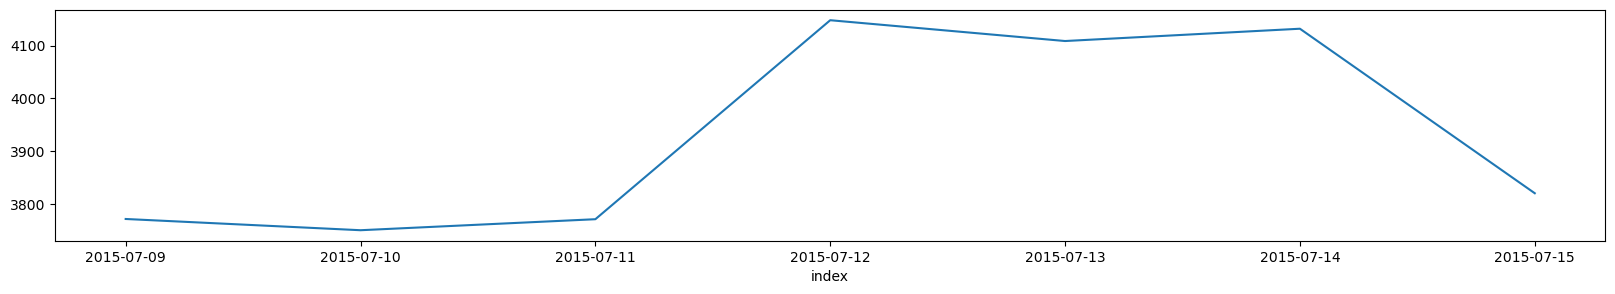

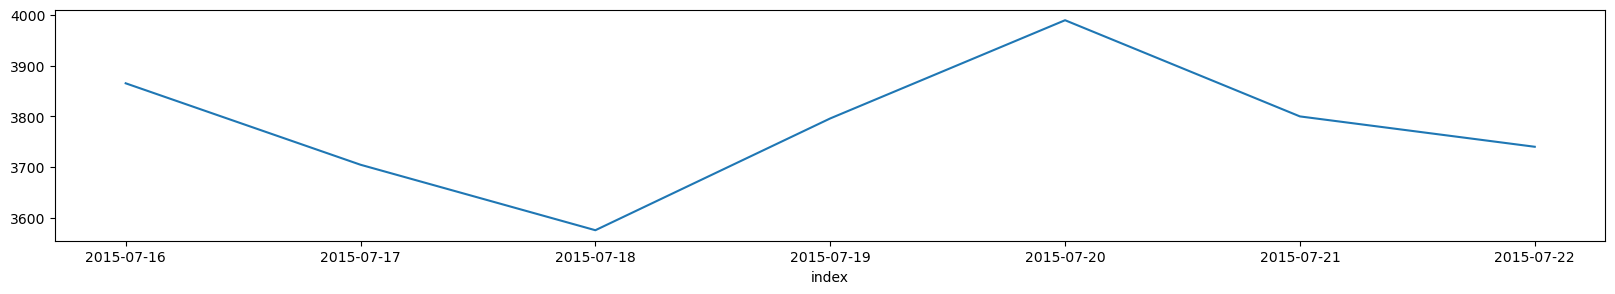

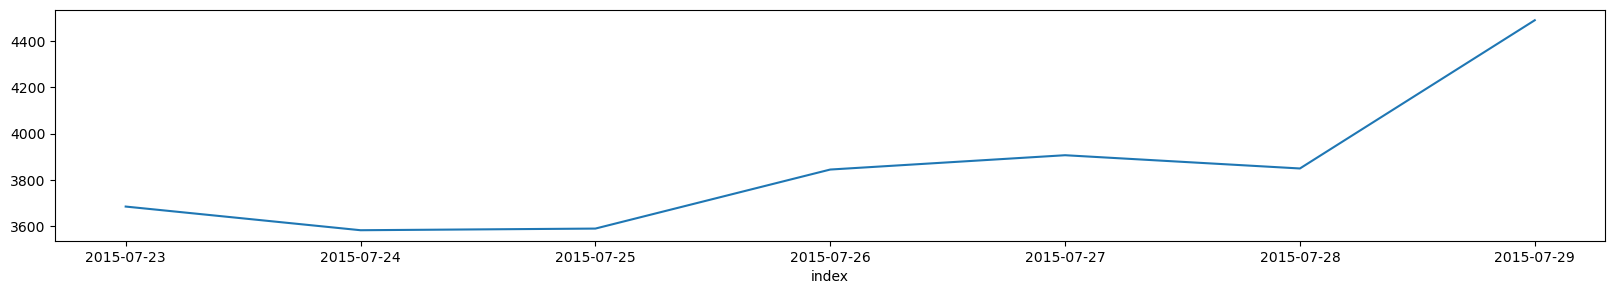

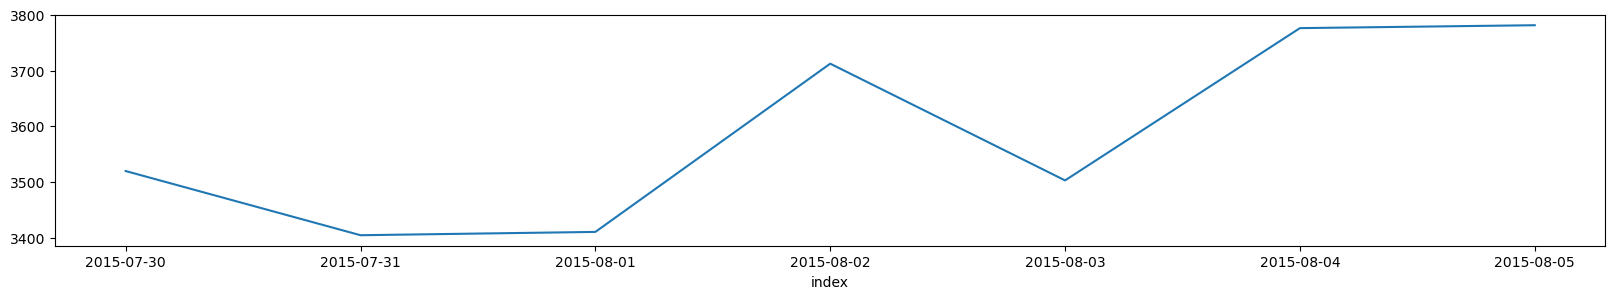

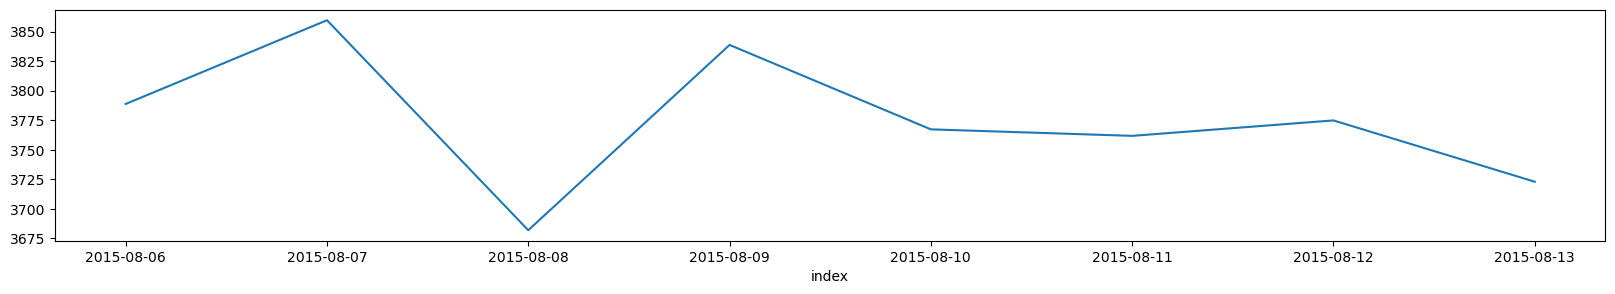

In [40]:
plt.rcParams['figure.figsize'] = (20, 3)

TS_English[:8].plot()
plt.show()
TS_English[8:15].plot()
plt.show()
TS_English[15:22].plot()
plt.show()
TS_English[22:29].plot()
plt.show()
TS_English[29:36].plot()
plt.show()

TS_English[36:44].plot()
plt.show()

In [41]:
correlations = []
for lag in range(1,30):
    present = TS_English[:-lag]
    past = TS_English.shift(-lag)[:-lag]
    corrs = np.corrcoef(present,past)[0][-1]
    print(lag,corrs)
    correlations.append(corrs)

1 0.9323258278620723
2 0.8605292614028011
3 0.8077278834799054
4 0.7714189806436796
5 0.7459471144093537
6 0.7371736771608727
7 0.7196991121158116
8 0.6689152573297469
9 0.6118380346312797
10 0.5743417993048073
11 0.554221239588739
12 0.5524322164036987
13 0.5722332092818787
14 0.5862794221805331
15 0.5683714328504221
16 0.5394957974018174
17 0.5180411465322313
18 0.5060807942249275
19 0.5111672452810425
20 0.522914434987449
21 0.5211517980871624
22 0.47391333853885614
23 0.41521040939999526
24 0.3702991226846805
25 0.33878104260208974
26 0.3209256187415589
27 0.3274071758868405
28 0.33341032818913385
29 0.3139433435132756


# Decomposing Time Series
In this case we have used Additive Model for deconstructing the time series. 
The term additive means individual components (trend, seasonality, and residual) are added together as shown in equation below:

$y_{t}$ =  $T_{t}$ +  $S_{t}$  +  $R_{t}$

where 
- $y_{t}$ = actual value in time series
- $T_{t}$ = trend in time series
- $S_{t}$ = seasonality in time series
- $R_{t}$ = residuals of time series

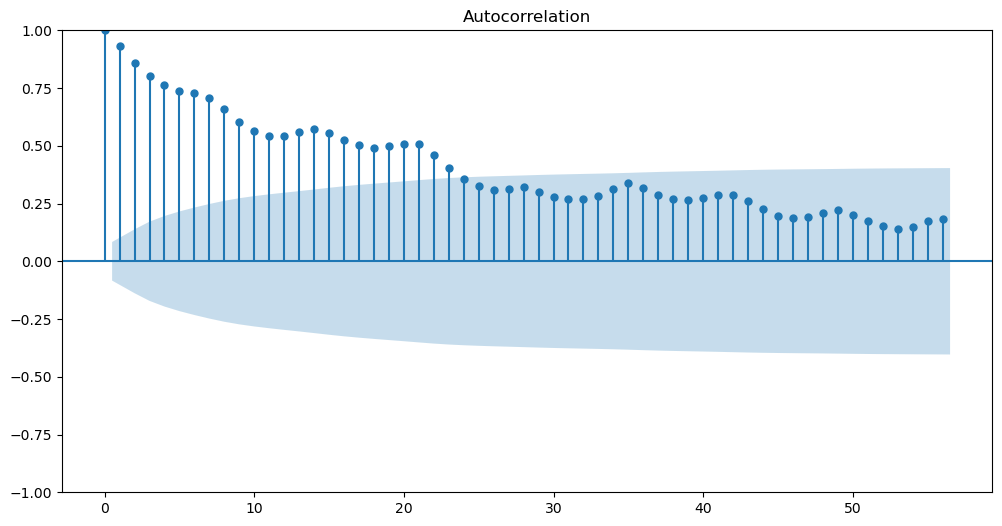

In [42]:
# using auto correlation function plot , to varify the period 

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.rcParams['figure.figsize'] = (12, 6)
plot_acf(TS_English,lags=56);

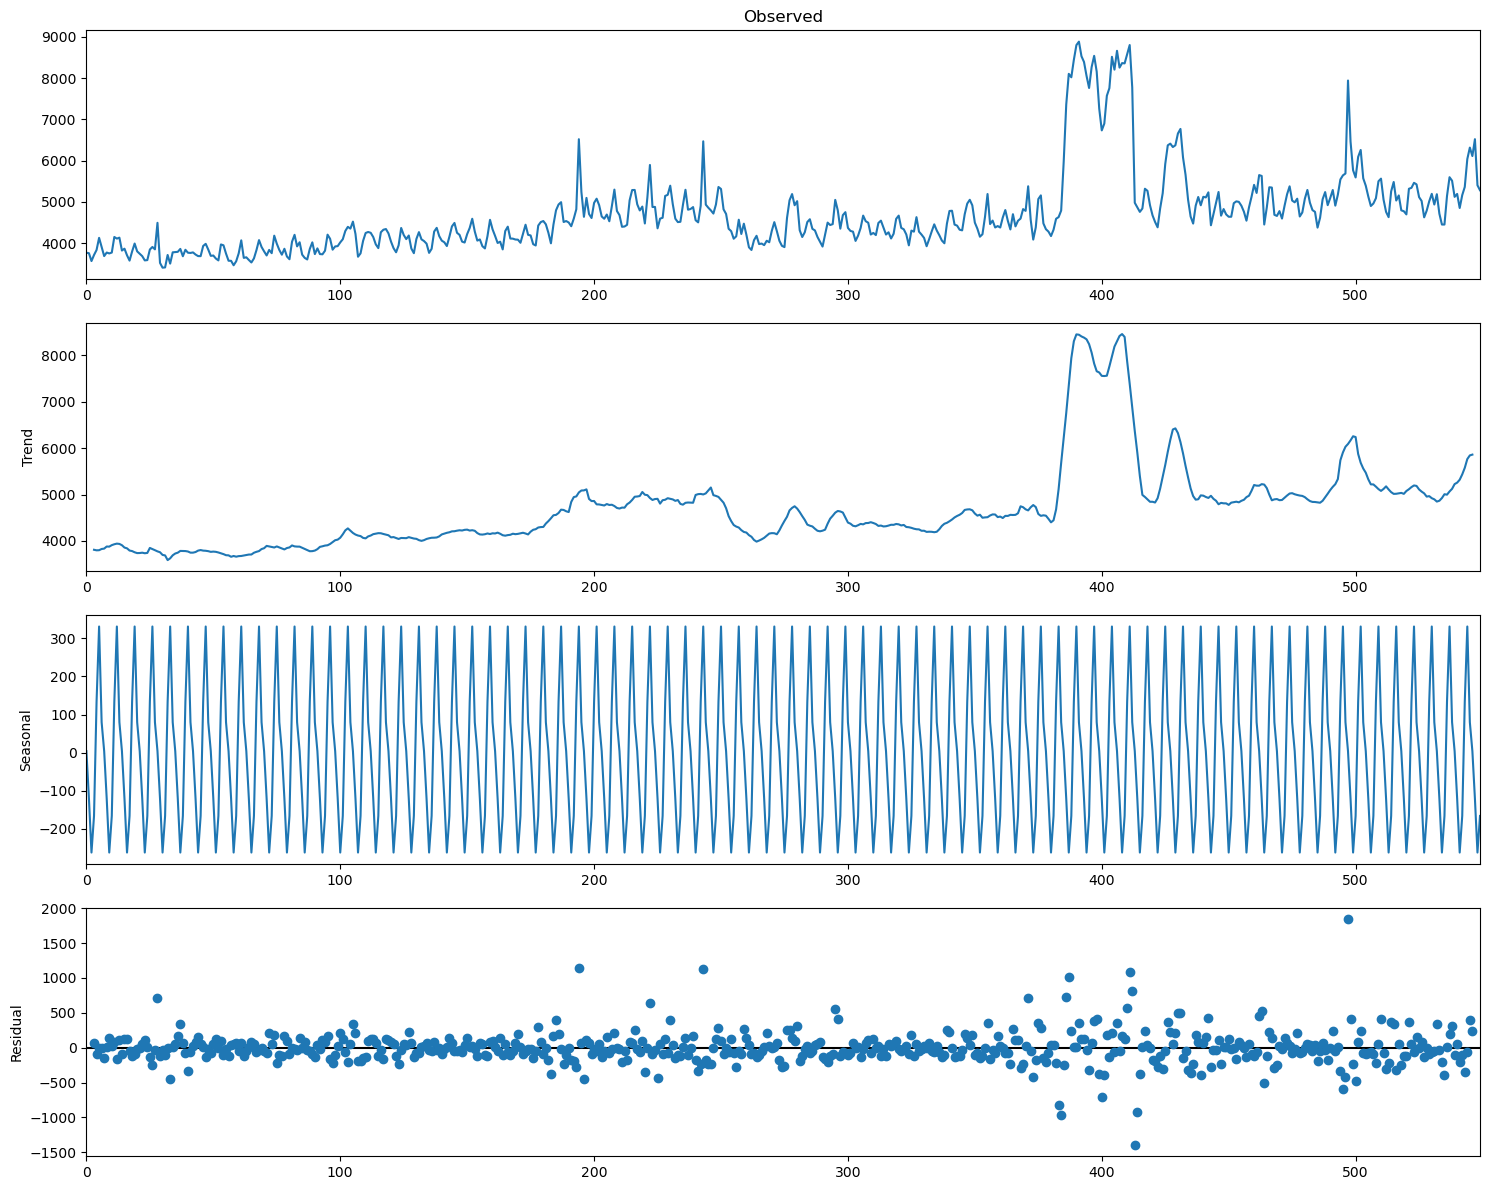

In [43]:
ts_english = data_language.English.values
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_english, model='additive', period=7)

fig = decomposition.plot()
fig.set_size_inches((15, 12))
fig.tight_layout()
plt.show()

In [44]:
residual = pd.DataFrame(decomposition.resid).fillna(0)[0].values
adf_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.152195e+01
p-value                        4.020092e-21
#Lags Used                     1.700000e+01
Number of Observations Used    5.320000e+02
Critical Value (1%)           -3.442702e+00
Critical Value (5%)           -2.866988e+00
Critical Value (10%)          -2.569672e+00
dtype: float64



- **The test statistic < critical value / p_value < 5%.**

From ADF (Augmented Dickey Fuller) Test it can be shown that **Residuals** from time-series decomposition is **Stationary**

## Estimating (p,q,d) & Interpreting ACF and PACF plots

In [45]:
ts_diff = pd.DataFrame(ts_english).diff(1)
ts_diff.dropna(inplace = True)

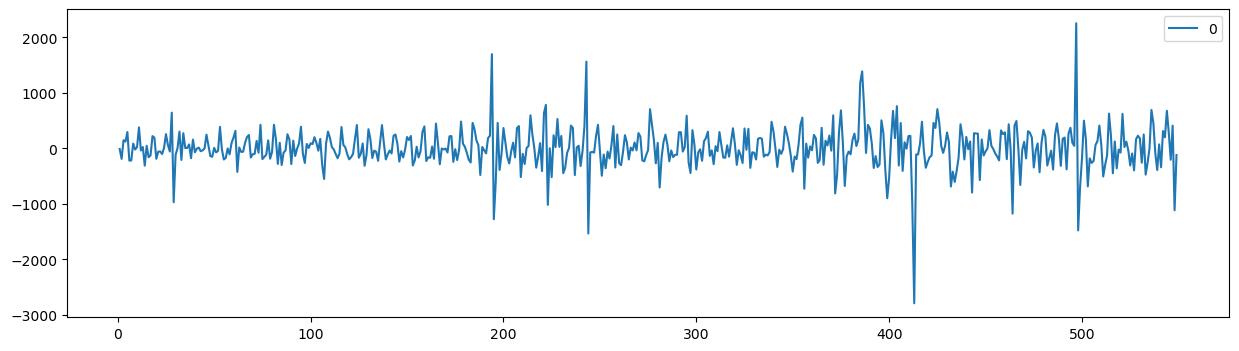

In [46]:
ts_diff.plot(figsize=(15, 4))
plt.show()

In [47]:
#ADF Test for differenced time-series
adf_test(ts_diff)
#p_value < 5%  ==> time series is stationary

Results of Dickey-Fuller Test:
Test Statistic                -8.273590e+00
p-value                        4.721272e-13
#Lags Used                     1.300000e+01
Number of Observations Used    5.350000e+02
Critical Value (1%)           -3.442632e+00
Critical Value (5%)           -2.866957e+00
Critical Value (10%)          -2.569655e+00
dtype: float64


* After one differencing time-series becomes stationary. This indicates for ARIMA model, we can set d = 1.

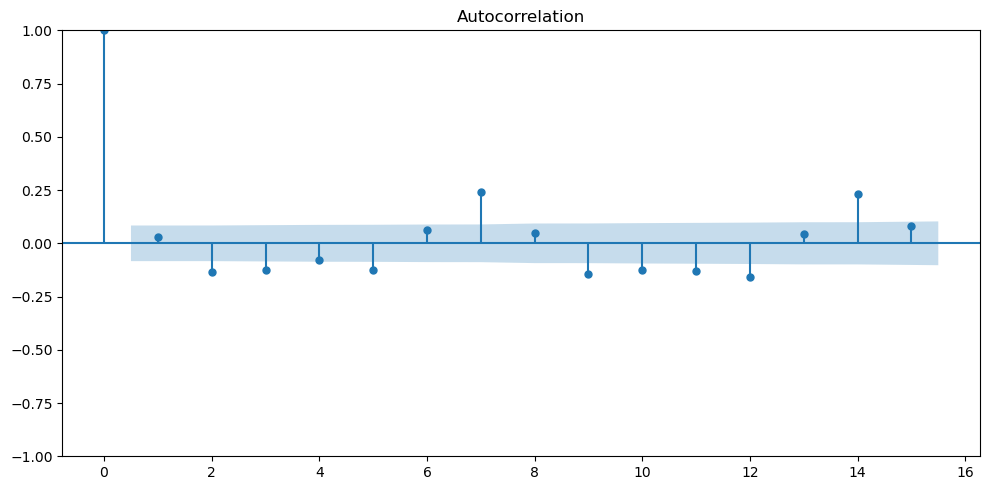

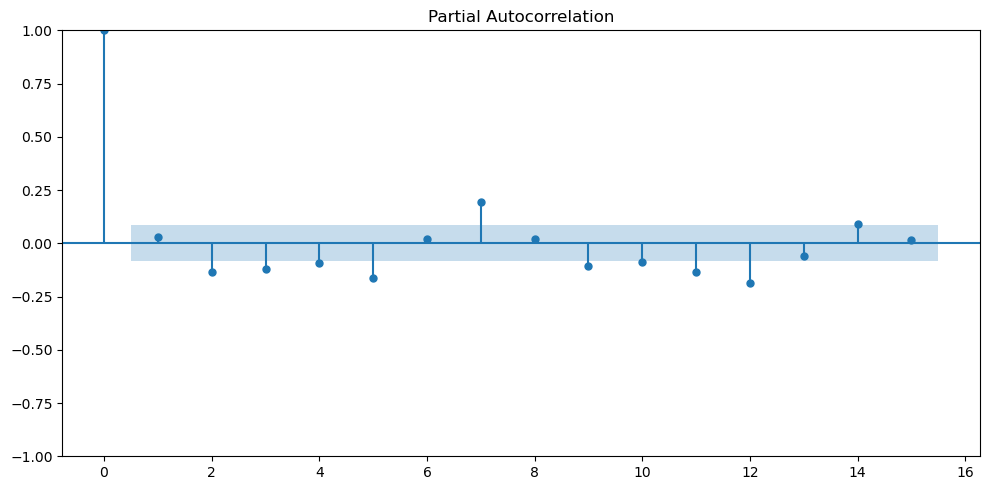

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(ts_diff, lags= 15)
acf.set_size_inches((10, 5))
acf.tight_layout()
pacf = plot_pacf(ts_diff, lags= 15)
pacf.set_size_inches((10, 5))
pacf.tight_layout()

* ACF & PACF indicates we should choose p = 0 & q = 0. But we will start with p=1 & q=1 for base ARIMA Model
# Forecasting Model Creation 

### ARIMA Base Model 

In [49]:
from statsmodels.tsa.arima.model import ARIMA

import warnings # supress warnings
warnings.filterwarnings('ignore')

n = 30
time_series = data_language.English.copy(deep = True)
#Creating Base ARIMA Model with order(1,1,1)
model = ARIMA(time_series[:-n], order =(1,1,1))
model_fit = model.fit()

#Creating forecast for last n-values
forecast = model_fit.forecast(steps = n, alpha = 0.05)

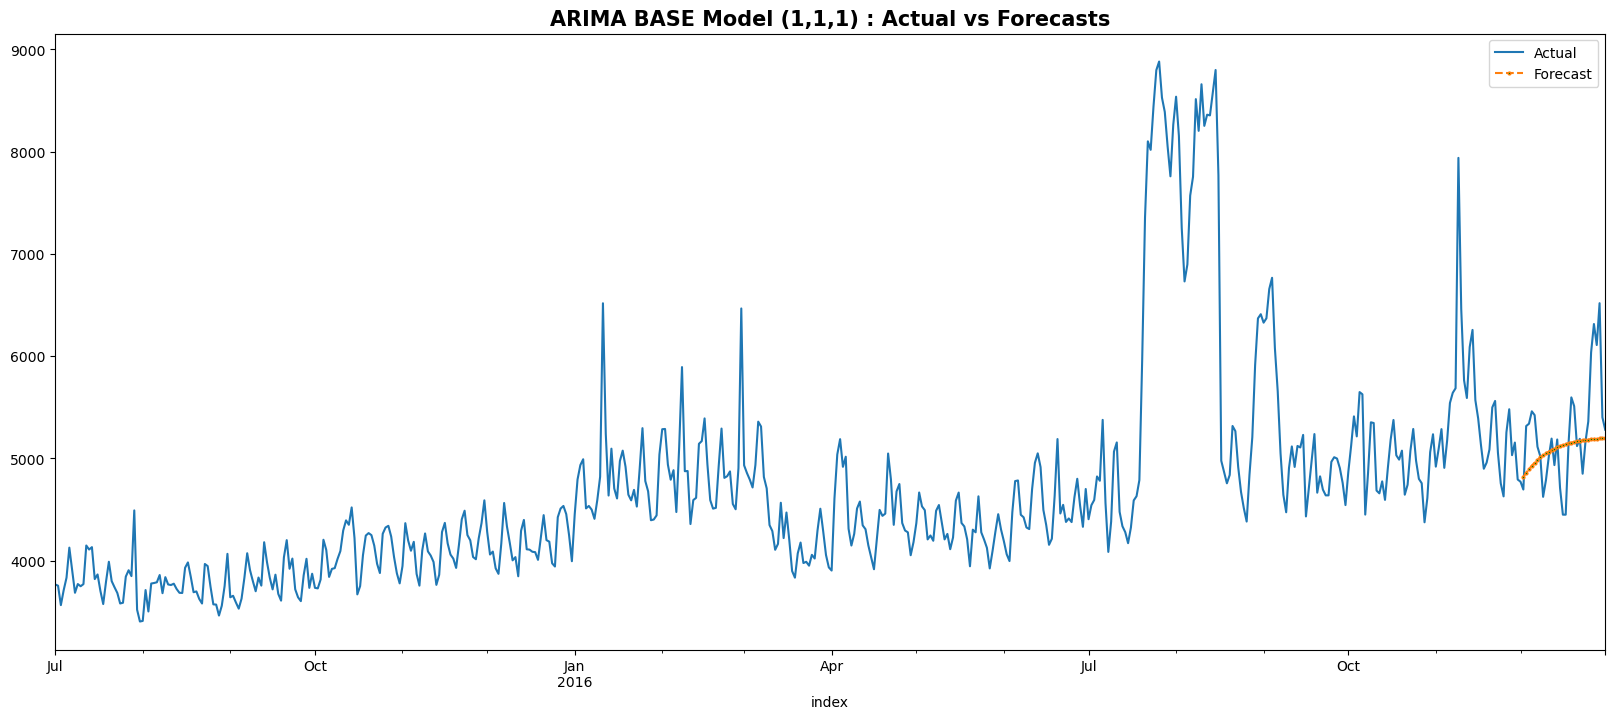

In [50]:
#plotting Actual & Forecasted values
time_series.index = time_series.index.astype('datetime64[ns]')
forecast.index = forecast.index.astype('datetime64[ns]')
plt.figure(figsize = (20,8))
time_series.plot(label = 'Actual')
forecast.plot(label = 'Forecast', linestyle='dashed', marker='o',markerfacecolor='green', markersize=2)
plt.legend(loc="upper right")
plt.title('ARIMA BASE Model (1,1,1) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
plt.show()

In [51]:
#Calculating MAPE & RMSE
actuals = time_series.values[-n:]
errors = time_series.values[-n:] - forecast.values

mape = np.mean(np.abs(errors)/ np.abs(actuals))
rmse = np.sqrt(np.mean(errors**2))

print(f'MAPE of Model : {np.round(mape,5)}')
print('-'*80)
print(f'RMSE of Model : {np.round(rmse,3)}')


MAPE of Model : 0.06691
--------------------------------------------------------------------------------
RMSE of Model : 496.72


* ARIMA Base model has ~6% MAPE and RMSE ~ 500.
## Creation for function for SARIMAX model 

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarimax_model(time_series, n, p=0, d=0, q=0, P=0, D=0, Q=0, s=0, exog = []):
    
    #Creating SARIMAX Model with order(p,d,q) & seasonal_order=(P, D, Q, s) 
    model = SARIMAX(time_series[:-n], \
                    order =(p,d,q), 
                    seasonal_order=(P, D, Q, s), 
                    exog = exog[:-n],
                    initialization='approximate_diffuse')
    model_fit = model.fit()
    
    #Creating forecast for last n-values
    model_forecast = model_fit.forecast(n, dynamic = True, exog = pd.DataFrame(exog[-n:]))
    
    #plotting Actual & Forecasted values
    time_series.index = time_series.index.astype('datetime64[ns]')
    model_forecast.index = model_forecast.index.astype('datetime64[ns]')
    plt.figure(figsize = (20,8))
    time_series[-60:].plot(label = 'Actual')
    model_forecast[-60:].plot(label = 'Forecast', color = 'red', 
                              linestyle='dashed', marker='o',markerfacecolor='green', markersize=5)
    plt.legend(loc="upper right")
    plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
    plt.show()
    
    #Calculating MAPE & RMSE
    actuals = time_series.values[-n:]
    errors = time_series.values[-n:] - model_forecast.values

    mape = np.mean(np.abs(errors)/ np.abs(actuals))
    rmse = np.sqrt(np.mean(errors**2))

    print(f'MAPE of Model : {np.round(mape,5)}')
    print('-'*80)
    print(f'RMSE of Model : {np.round(rmse,3)}')


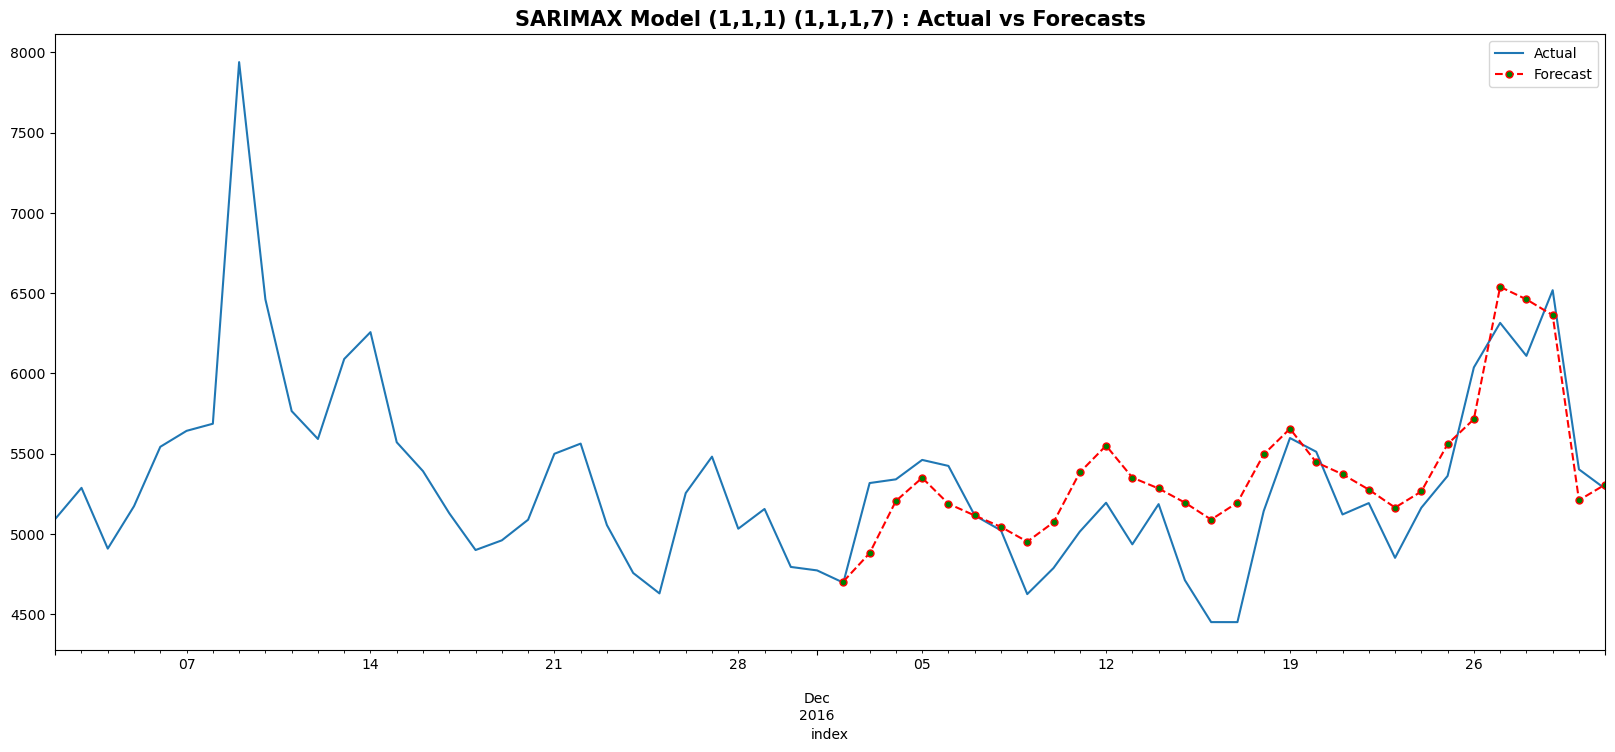

MAPE of Model : 0.04848
--------------------------------------------------------------------------------
RMSE of Model : 305.342


In [53]:
#Checking a SARIMAX model with seasonality (p,d,q,P,D,Q,s = 1,1,1,1,1,1,7)
exog = Exog_Campaign_eng['Exog'].to_numpy()
time_series = data_language.English
test_size= 0.1
p,d,q, P,D,Q,s = 1,1,1,1,1,1,7
n = 30
sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog = exog)

* SIMPLE SARIMAX model has ~4.9% MAPE and RMSE ~ 300.

* Impact of Seasonality & exogenous variable was captured properly in this model.
## Searching for best parameters for SARIMAX model 
### Finding Best parameters for 'English' Pages 

In [54]:
def sarimax_grid_search(time_series, n, param, d_param, s_param, exog = []):
    counter = 0
    #creating df for storing results summary
    param_df = pd.DataFrame(columns = ['serial','pdq', 'PDQs', 'mape', 'rmse'])
    
    #Creating loop for every paramater to fit SARIMAX model
    for p in param:
        for d in d_param:
            for q in param:
                for P in param:
                    for D in d_param:
                        for Q in param:
                            for s in s_param:
                                #Creating Model
                                model = SARIMAX(time_series[:-n], 
                                                order=(p,d,q), 
                                                seasonal_order=(P, D, Q, s), 
                                                exog = exog[:-n],
                                                initialization='approximate_diffuse')
                                model_fit = model.fit()
                                
                                #Creating forecast from Model
                                model_forecast = model_fit.forecast(n, dynamic = True, exog = pd.DataFrame(exog[-n:]))
                                
                                #Calculating errors for results
                                actuals = time_series.values[-n:]
                                errors = time_series.values[-n:] - model_forecast.values
                                
                                #Calculating MAPE & RMSE
                                mape = np.mean(np.abs(errors)/ np.abs(actuals))
                                rmse = np.sqrt(np.mean(errors**2))
                                mape = np.round(mape,5)
                                rmse = np.round(rmse,3)
                                
                                #Storing the results in param_df
                                counter += 1
                                list_row = [counter, (p,d,q), (P,D,Q,s), mape, rmse]
                                param_df.loc[len(param_df)] = list_row
                                
                #print statement to check progress of Loop                
                print(f'Possible Combination: {counter} out of { (len(param)**4)*len(s_param)*(len(d_param)**2)} calculated')
                           
    return param_df     

In [55]:
#long time to execute
#Finding best parameters for English time series
exog = Exog_Campaign_eng['Exog'].to_numpy()
time_series = data_language.English
n = 30 
param = [0,1,2]
d_param = [0,1]
s_param = [7]

english_params  = sarimax_grid_search(time_series, n, param, d_param,s_param, exog)

Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 252 out of 324 calculated
Possible Combination: 270 out of 324 calculated
Possible Combination: 288 out of 324 calculated
Possible Combination: 306 out of 324 calculated
Possible Combination: 324 out of 324 calculated


In [56]:
english_params.sort_values(['mape', 'rmse']).head()

,serial,pdq,PDQs,mape,rmse
196,197,"(1, 1, 1)","(2, 1, 1, 7)",0.04192,272.593
41,42,"(0, 0, 2)","(0, 1, 2, 7)",0.04325,287.492
317,318,"(2, 1, 2)","(1, 1, 2, 7)",0.04333,276.101
46,47,"(0, 0, 2)","(1, 1, 1, 7)",0.04334,285.221
47,48,"(0, 0, 2)","(1, 1, 2, 7)",0.04347,286.642


* Best Possible parameters English Time Series are pdq = (1, 1, 1) & PDQs = (2, 1, 1, 7).

* Minimum MAPE = 4.189% and corresponding RMSE = 272.188.

In [57]:
#Function to fetch best parameters for each language

def pipeline_sarimax_grid_search_without_exog(languages, data_language, n, param, d_param, s_param):
    
    best_param_df  = pd.DataFrame(columns = ['language','p','d', 'q', 'P','D','Q','s','mape'])
    for lang in languages:
        print('')
        print('')
        print(f'--------------------------------------------------------------')
        print(f'          Finding best parameters for {lang}                  ')
        print(f'--------------------------------------------------------------')
        counter = 0
        time_series = data_language[lang]
        #creating df for storing results summary
        #param_df = pd.DataFrame(columns = ['serial','pdq', 'PDQs', 'mape', 'rmse'])
        best_mape = 100
        
        #Creating loop for every paramater to fit SARIMAX model
        for p in param:
            for d in d_param:
                for q in param:
                    for P in param:
                        for D in d_param:
                            for Q in param:
                                for s in s_param:
                                    #Creating Model
                                    model = SARIMAX(time_series[:-n], 
                                                    order=(p,d,q), 
                                                    seasonal_order=(P, D, Q, s), 
                                                    initialization='approximate_diffuse')
                                    model_fit = model.fit()

                                    #Creating forecast from Model
                                    model_forecast = model_fit.forecast(n, dynamic = True)

                                    #Calculating errors for results
                                    actuals = time_series.values[-n:]
                                    errors = time_series.values[-n:] - model_forecast.values

                                    #Calculating MAPE & RMSE
                                    mape = np.mean(np.abs(errors)/ np.abs(actuals))
                                    
                                    counter += 1

                                    if (mape < best_mape):
                                        best_mape = mape
                                        best_p = p
                                        best_d = d
                                        best_q = q
                                        best_P = P
                                        best_D = D
                                        best_Q = Q
                                        best_s = s
                                    else: pass

                    #print statement to check progress of Loop                
                    print(f'Possible Combination: {counter} out of {(len(param)**4)*len(s_param)*(len(d_param)**2)} calculated')

        best_mape = np.round(best_mape, 5)
        print(f'--------------------------------------------------------------')
        print(f'Minimum MAPE for {lang} = {best_mape}')
        print(f'Corresponding Best Parameters are {best_p , best_d, best_q, best_P, best_D, best_Q, best_s}')
        print(f'--------------------------------------------------------------')
        
        best_param_row = [lang, best_p, best_d, best_q, best_P, best_D, best_Q, best_s, best_mape]
        best_param_df.loc[len(best_param_df)] = best_param_row                
                           
    return best_param_df     

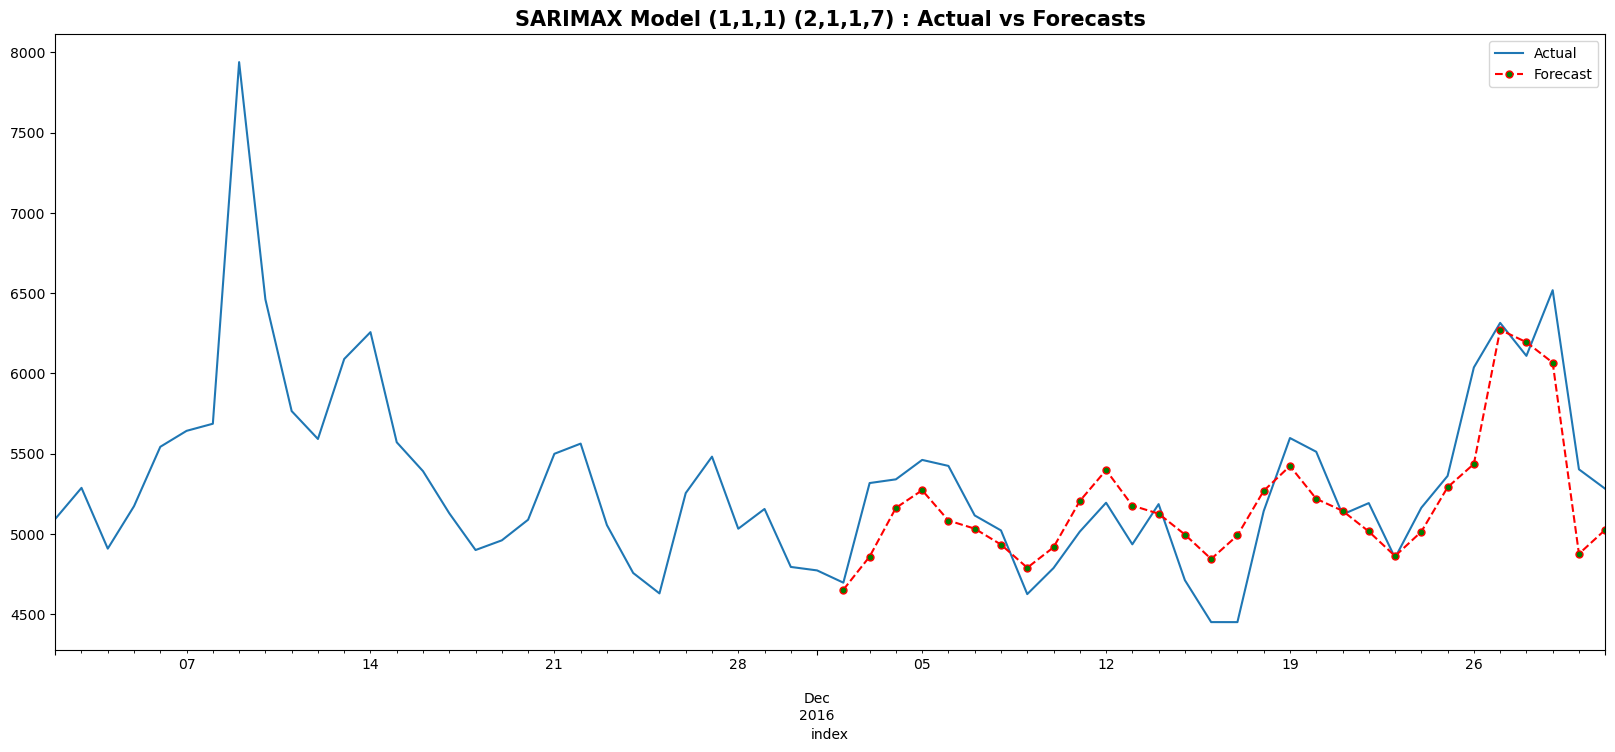

MAPE of Model : 0.04192
--------------------------------------------------------------------------------
RMSE of Model : 272.593


In [58]:
#Plotting the SARIMAX model corresponding to best parameters
exog = Exog_Campaign_eng['Exog'].to_numpy()
time_series = data_language.English
p,d,q, P,D,Q,s = 1,1,1, 2,1,1,7
n = 30
sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog = exog)

## Creating Pipeline to search Best parameters for all Page

In [59]:
#long time to execute
#calculating best parameters for all languages
languages = ['Chinese', 'French', 'German', 'Japenese', 'Russian', 'Spanish']
n = 30 
param = [0,1,2]
d_param = [0,1]
s_param = [7]

best_param_df = pipeline_sarimax_grid_search_without_exog(languages, data_language, n, param, d_param, s_param)



--------------------------------------------------------------
          Finding best parameters for Chinese                  
--------------------------------------------------------------
Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 252 out of 324 calculated
Possible Combination: 270 out of 324 calculated
Possible Combination: 288 out of 324 calculated
Possible Combination: 306 out of 324 calculat

In [60]:
best_param_df.sort_values(['mape'], inplace = True)
best_param_df

,language,p,d,q,P,D,Q,s,mape
0,Chinese,0,1,1,0,0,2,7,0.03352
4,Russian,1,0,2,2,0,1,7,0.05261
1,French,0,0,2,2,1,2,7,0.05989
2,German,2,1,0,0,1,1,7,0.06553
3,Japenese,0,0,2,2,0,2,7,0.07279
5,Spanish,0,1,0,2,1,0,7,0.08209


In [61]:
#Function to plot SARIMAX model for each Language

def plot_best_SARIMAX_model(languages, data_language, n, best_param_df):
    
    for lang in languages:
        #fetching respective best parameters for that language
        p = best_param_df.loc[best_param_df['language'] == lang, ['p']].values[0][0]
        d = best_param_df.loc[best_param_df['language'] == lang, ['d']].values[0][0]
        q = best_param_df.loc[best_param_df['language'] == lang, ['q']].values[0][0]
        P = best_param_df.loc[best_param_df['language'] == lang, ['P']].values[0][0]
        D = best_param_df.loc[best_param_df['language'] == lang, ['D']].values[0][0]
        Q = best_param_df.loc[best_param_df['language'] == lang, ['Q']].values[0][0]
        s = best_param_df.loc[best_param_df['language'] == lang, ['s']].values[0][0]
        
        #Creating language time-series
        time_series = data_language[lang]
        
        #Creating SARIMAX Model with order(p,d,q) & seasonal_order=(P, D, Q, s) 
        model = SARIMAX(time_series[:-n], 
                        order =(p,d,q), 
                        seasonal_order=(P, D, Q, s),
                        initialization='approximate_diffuse')
        model_fit = model.fit()
        
        #Creating forecast for last n-values
        model_forecast = model_fit.forecast(n, dynamic = True)
        
        #Calculating MAPE & RMSE
        actuals = time_series.values[-n:]
        errors = time_series.values[-n:] - model_forecast.values

        mape = np.mean(np.abs(errors)/ np.abs(actuals))
        rmse = np.sqrt(np.mean(errors**2))
        
        print('')
        print('')
        print(f'-----------------------------------------------------------------------------------------')
        print(f'        SARIMAX model for {lang} Time Series                                             ')
        print(f'        Parameters of Model : ({p},{d},{q}) ({P},{D},{Q},{s})                            ')
        print(f'        MAPE of Model       : {np.round(mape,5)}                                         ')
        print(f'        RMSE of Model       : {np.round(rmse,3)}                                         ')
        print(f'-----------------------------------------------------------------------------------------')
        
        #plotting Actual & Forecasted values
        time_series.index = time_series.index.astype('datetime64[ns]')
        model_forecast.index = model_forecast.index.astype('datetime64[ns]')
        plt.figure(figsize = (20,8))
        time_series[-60:].plot(label = 'Actual')
        model_forecast[-60:].plot(label = 'Forecast', color = 'red', 
                                  linestyle='dashed', marker='o',markerfacecolor='green', markersize=5)
        plt.legend(loc="upper right")
        plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
        plt.show()
    
    return 0



-----------------------------------------------------------------------------------------
        SARIMAX model for Chinese Time Series                                             
        Parameters of Model : (0,1,1) (0,0,2,7)                            
        MAPE of Model       : 0.03352                                         
        RMSE of Model       : 16.433                                         
-----------------------------------------------------------------------------------------


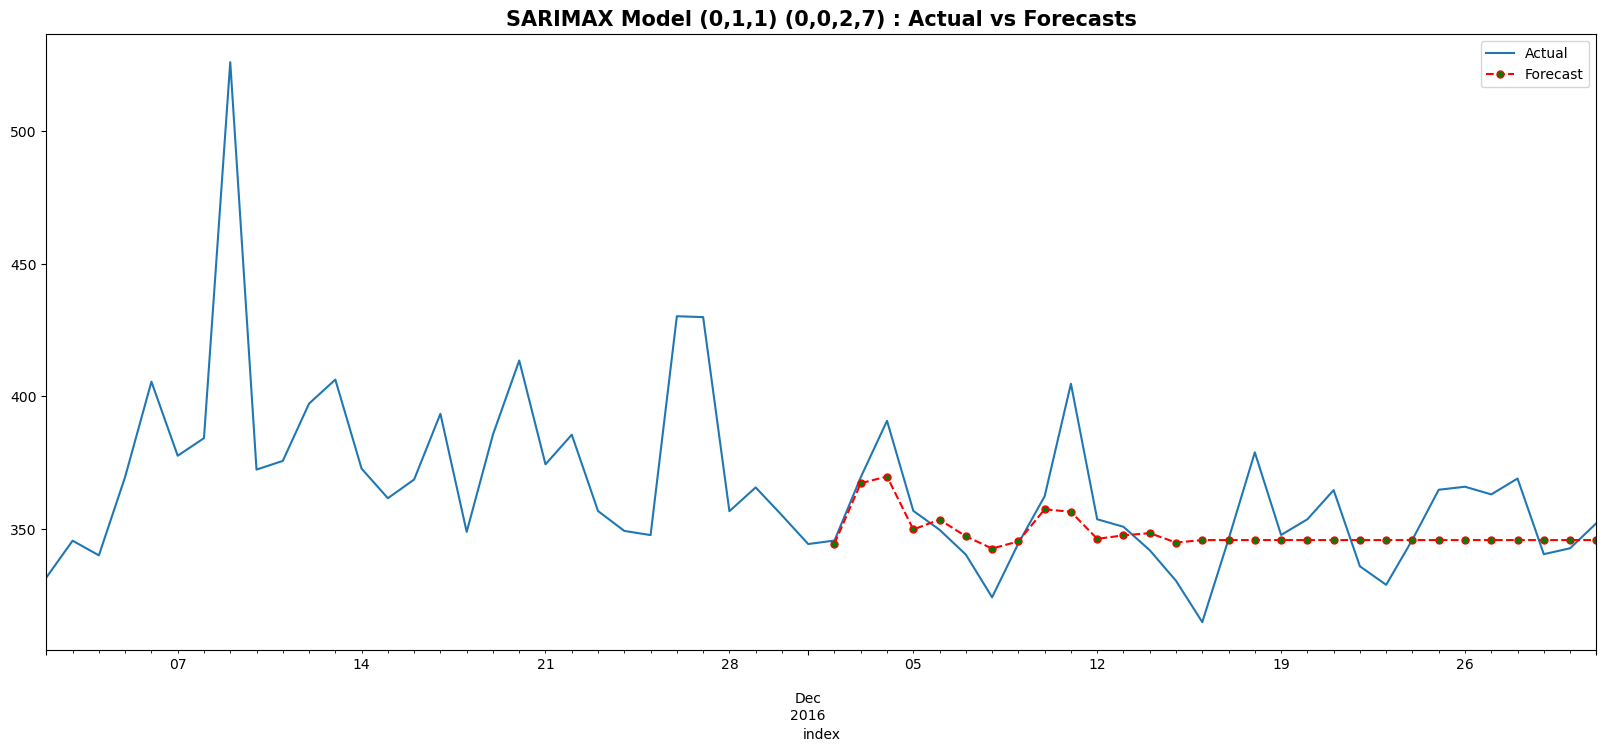



-----------------------------------------------------------------------------------------
        SARIMAX model for French Time Series                                             
        Parameters of Model : (0,0,2) (2,1,2,7)                            
        MAPE of Model       : 0.05989                                         
        RMSE of Model       : 62.201                                         
-----------------------------------------------------------------------------------------


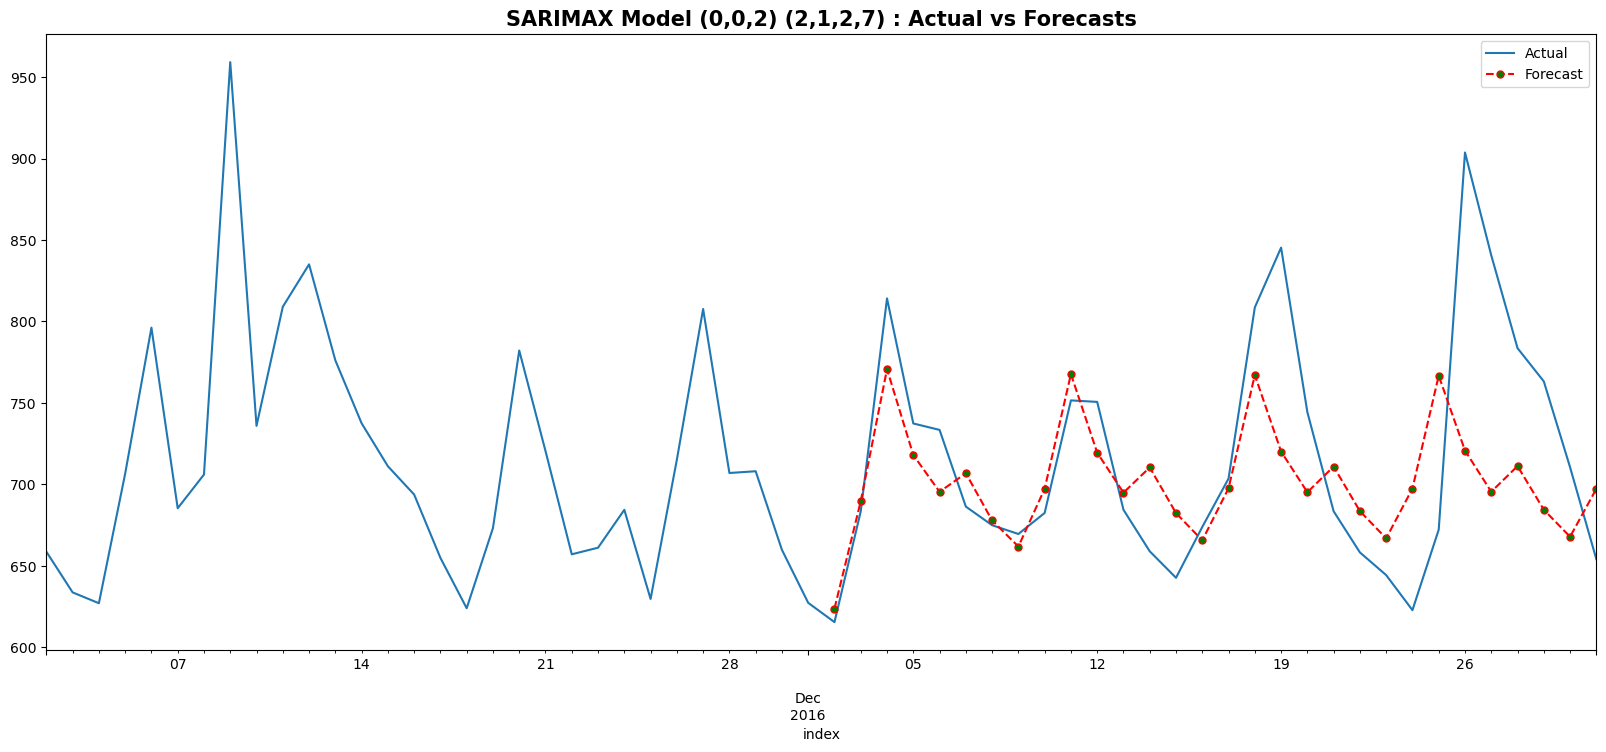



-----------------------------------------------------------------------------------------
        SARIMAX model for German Time Series                                             
        Parameters of Model : (2,1,0) (0,1,1,7)                            
        MAPE of Model       : 0.06553                                         
        RMSE of Model       : 112.628                                         
-----------------------------------------------------------------------------------------


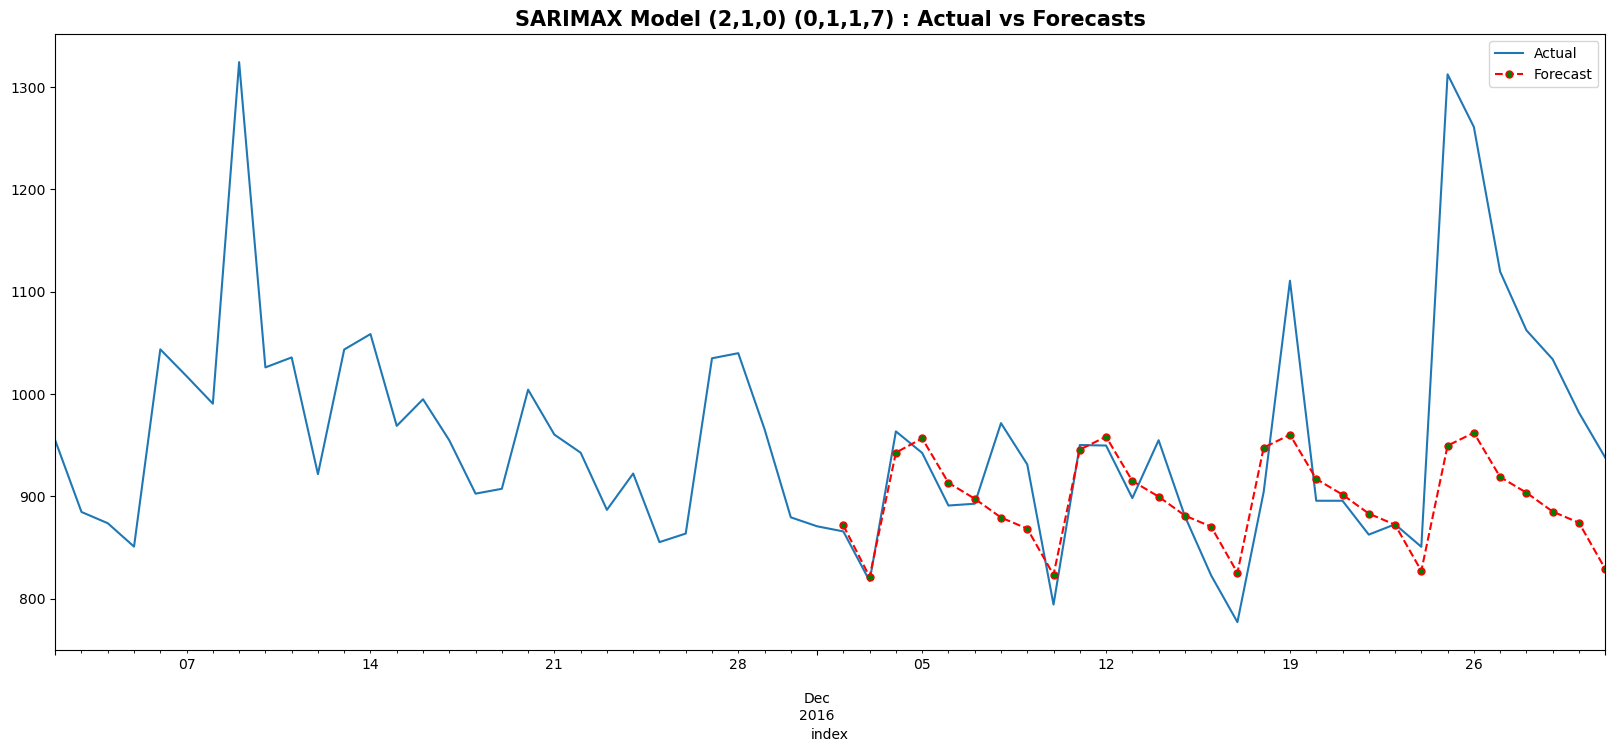



-----------------------------------------------------------------------------------------
        SARIMAX model for Japenese Time Series                                             
        Parameters of Model : (0,0,2) (2,0,2,7)                            
        MAPE of Model       : 0.07279                                         
        RMSE of Model       : 107.14                                         
-----------------------------------------------------------------------------------------


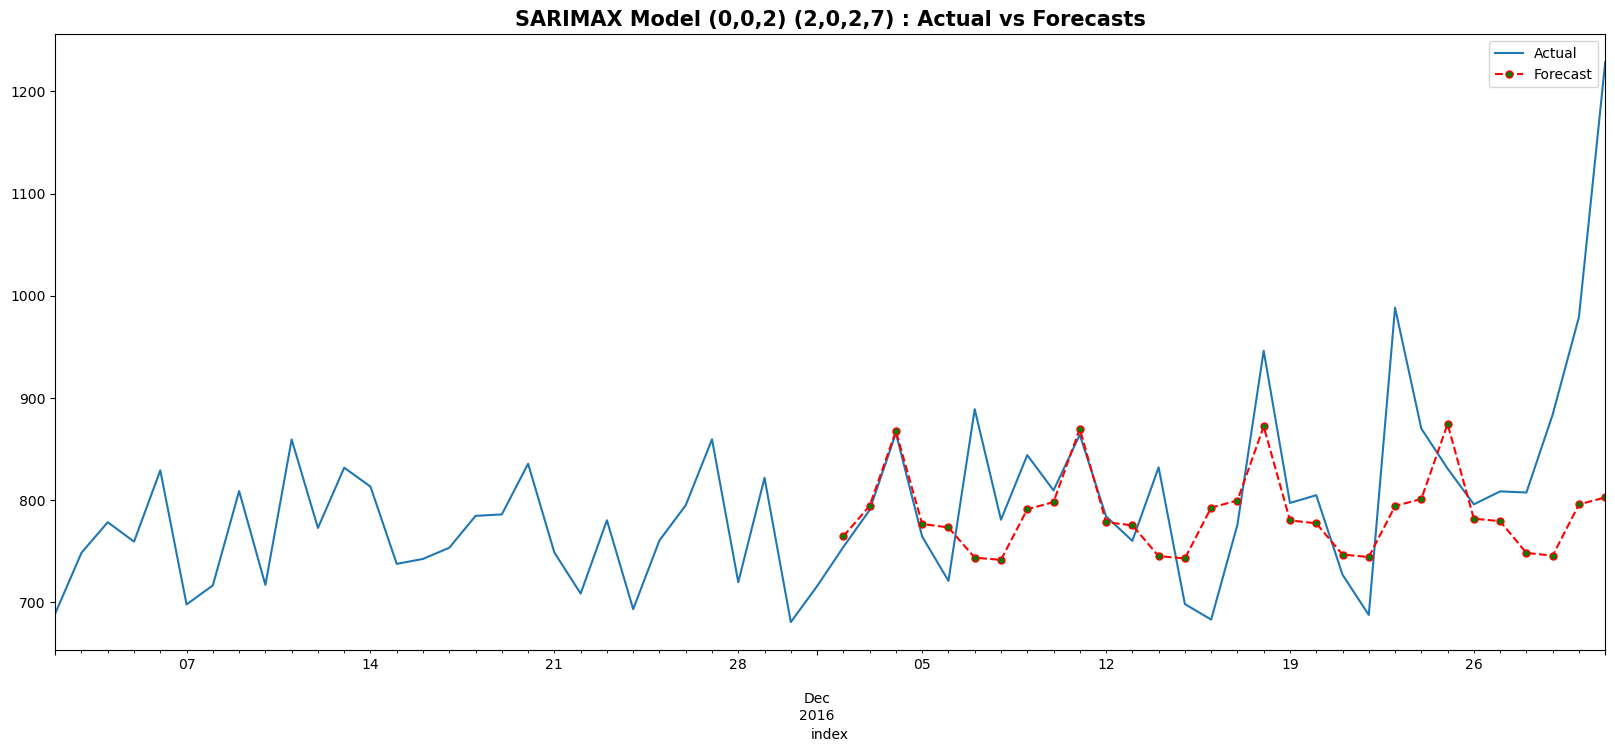



-----------------------------------------------------------------------------------------
        SARIMAX model for Russian Time Series                                             
        Parameters of Model : (1,0,2) (2,0,1,7)                            
        MAPE of Model       : 0.05261                                         
        RMSE of Model       : 63.814                                         
-----------------------------------------------------------------------------------------


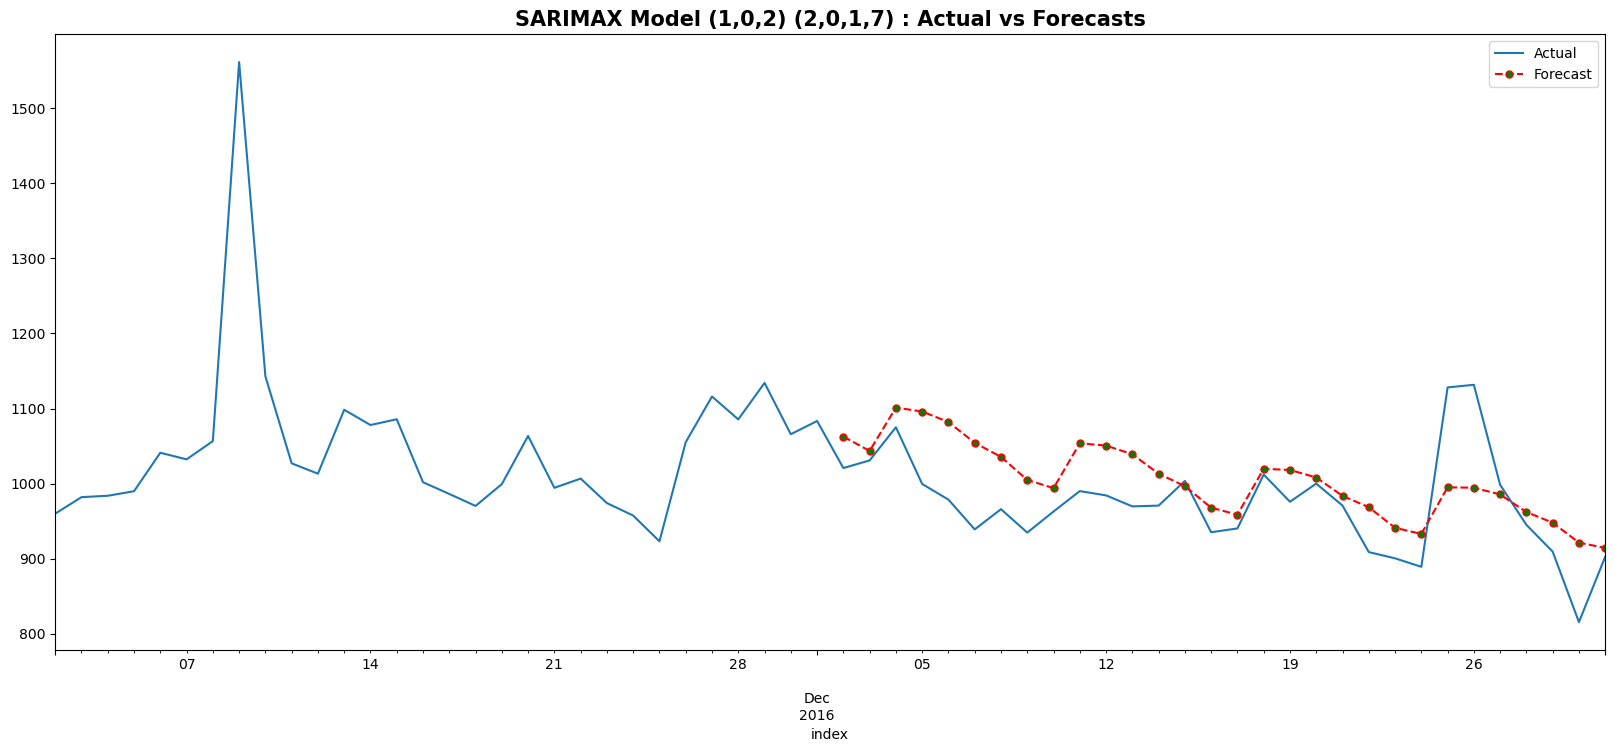



-----------------------------------------------------------------------------------------
        SARIMAX model for Spanish Time Series                                             
        Parameters of Model : (0,1,0) (2,1,0,7)                            
        MAPE of Model       : 0.08209                                         
        RMSE of Model       : 100.474                                         
-----------------------------------------------------------------------------------------


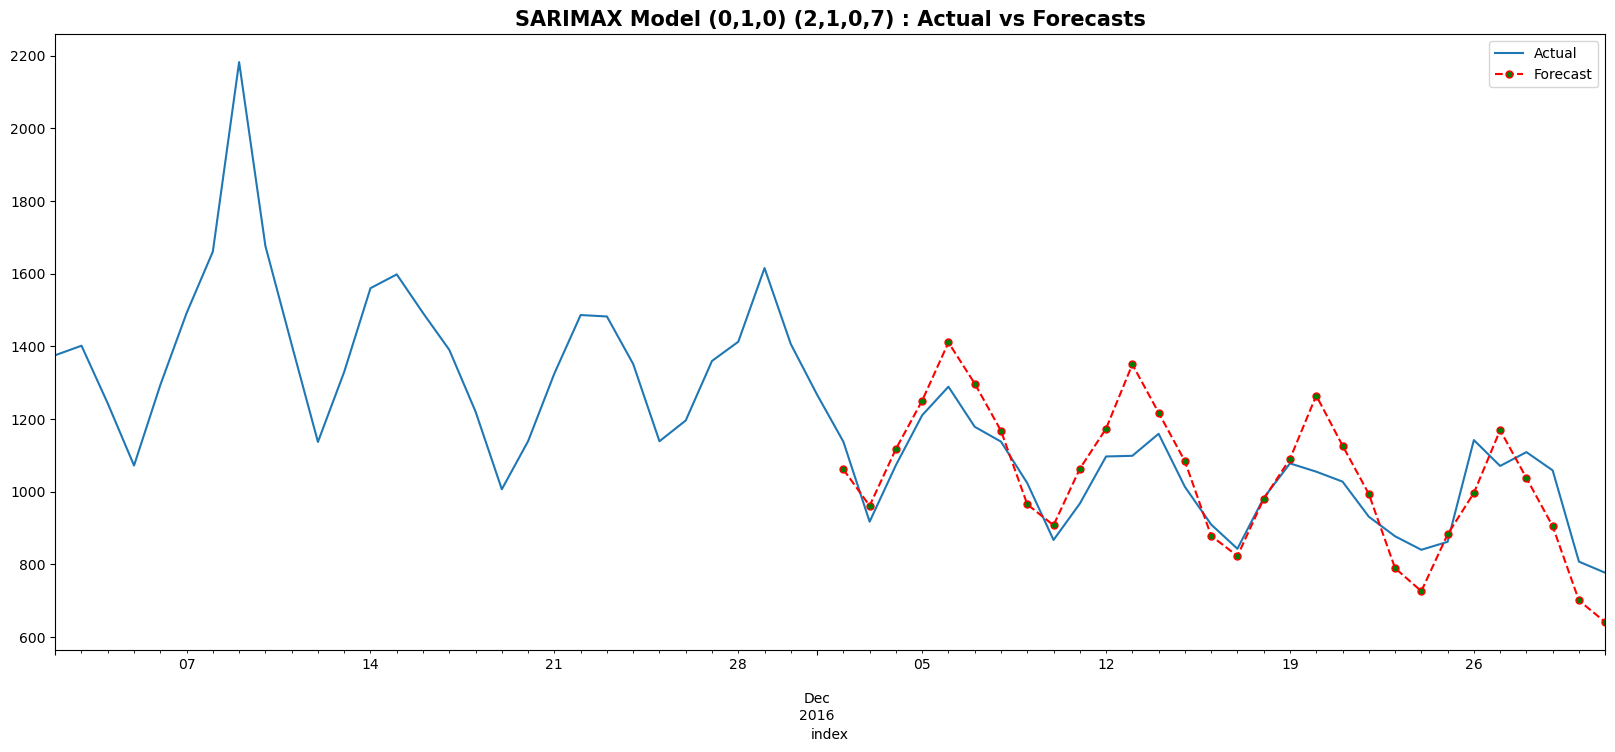

0

In [62]:
#Plotting SARIMAX model for each Language Time Series
languages = ['Chinese', 'French', 'German', 'Japenese', 'Russian', 'Spanish']
n = 30 
plot_best_SARIMAX_model(languages, data_language, n, best_param_df)

## Forecasting using Facebook Prophet 

In [63]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [64]:
time_series = data_language
time_series = time_series.reset_index()
time_series = time_series[['index', 'English']]
time_series.columns = ['ds', 'y']
exog = Exog_Campaign_eng.copy(deep = True)
time_series['exog'] = exog.values

In [65]:
time_series

,ds,y,exog
0,2015-07-01,3767.328604,0
1,2015-07-02,3755.158765,0
2,2015-07-03,3565.225696,0
3,2015-07-04,3711.782932,0
4,2015-07-05,3833.433025,0
...,...,...,...
545,2016-12-27,6314.335275,1
546,2016-12-28,6108.874144,1
547,2016-12-29,6518.058525,1
548,2016-12-30,5401.792360,0


23:16:26 - cmdstanpy - INFO - Chain [1] start processing
23:16:27 - cmdstanpy - INFO - Chain [1] done processing


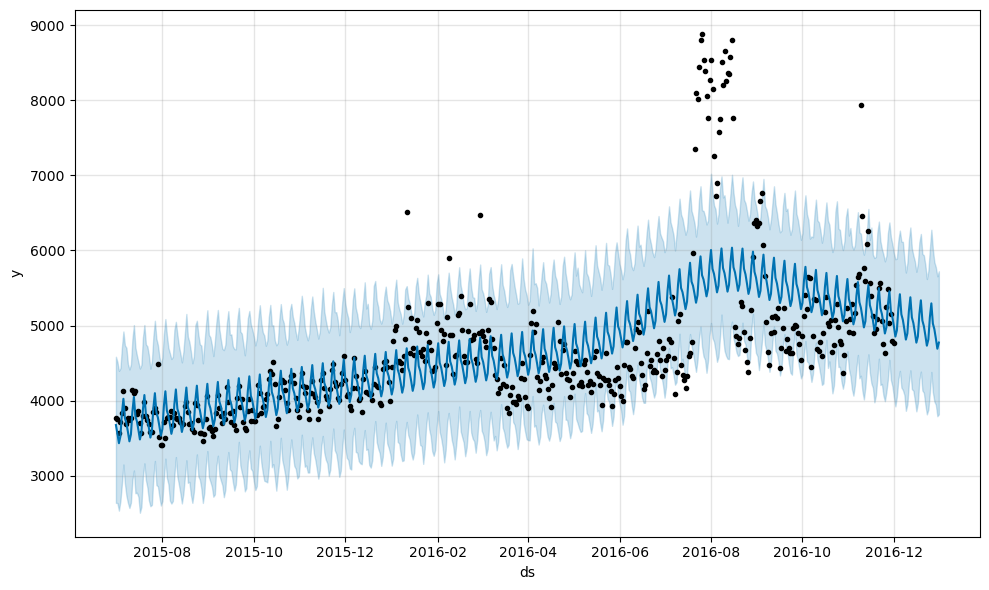

In [66]:
prophet1 = Prophet(weekly_seasonality=True)
prophet1.fit(time_series[['ds', 'y']][:-30])
future = prophet1.make_future_dataframe(periods=30, freq= 'D')
forecast = prophet1.predict(future)
fig1 = prophet1.plot(forecast)

23:16:29 - cmdstanpy - INFO - Chain [1] start processing
23:16:30 - cmdstanpy - INFO - Chain [1] done processing


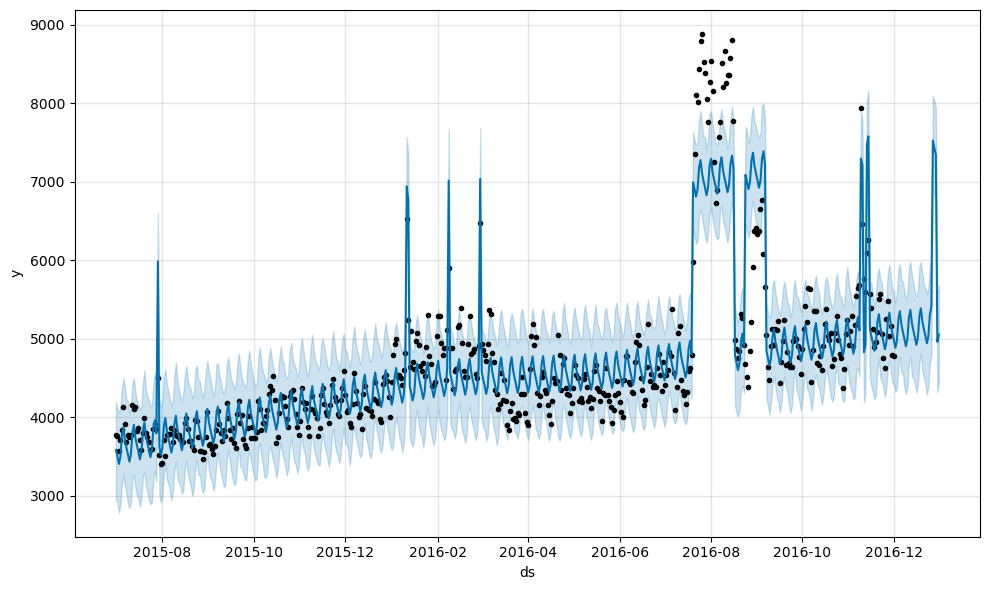

In [67]:
prophet2 = Prophet(weekly_seasonality=True)
prophet2.add_regressor('exog')
prophet2.fit(time_series[:-30])
#future2 = prophet2.make_future_dataframe(periods=30, freq= 'D')
forecast2 = prophet2.predict(time_series)
fig2 = prophet2.plot(forecast2)

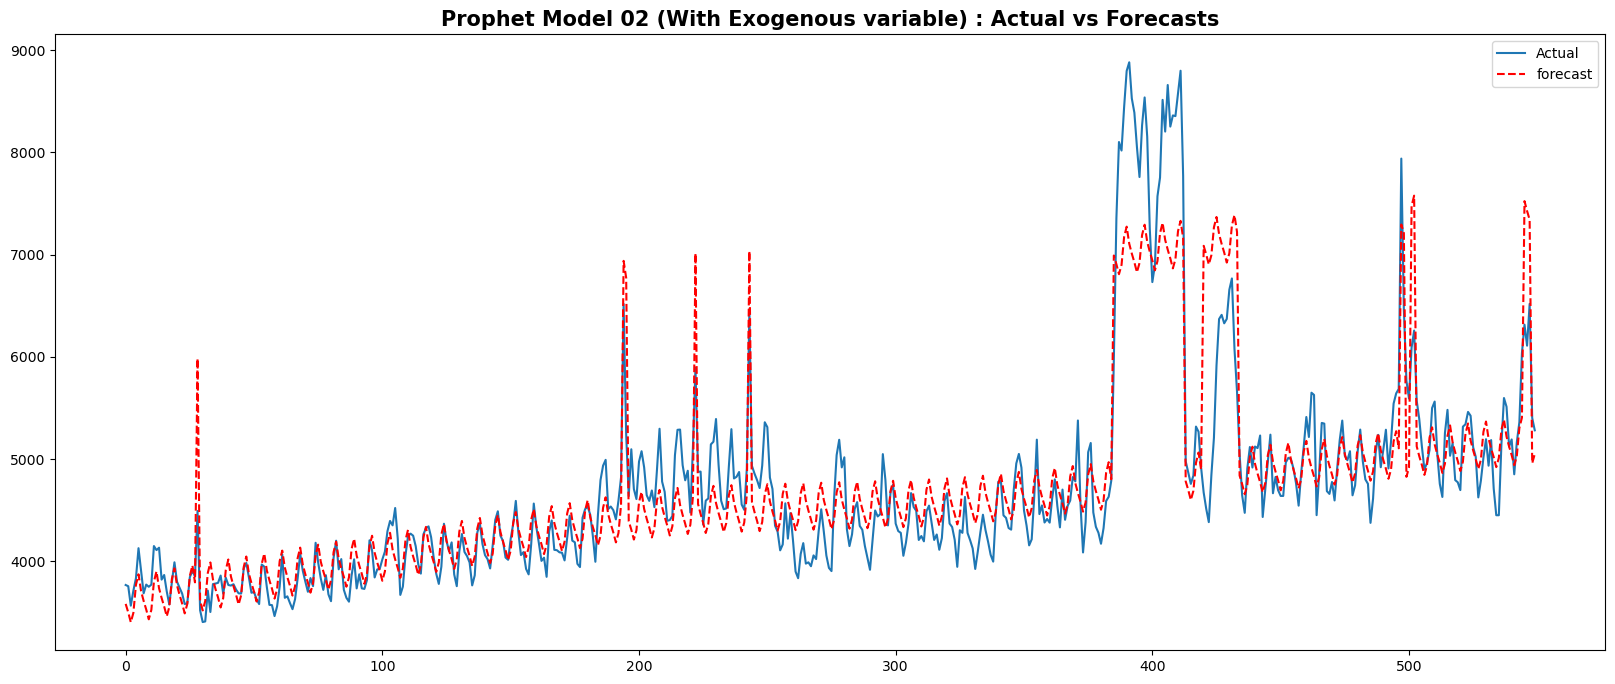

In [68]:
actual = time_series['y'].values
forecast = forecast2['yhat'].values

plt.figure(figsize = (20,8))
plt.plot(actual, label = 'Actual')
plt.plot(forecast, label = 'forecast', color = 'red', linestyle='dashed')
plt.legend(loc="upper right")
plt.title(f'Prophet Model 02 (With Exogenous variable) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
plt.show()

In [69]:
errors = abs(actual - forecast)
mape = np.mean(errors/abs(actual))
mape

0.059846174776769345

FB Prophet Model was created successfully. Forecast seems decent. This model is able to capture peaks because of exogenous variable.

Overall MAPE from Prophet model = ~6%
# Business decisions / Recommendations 
### MAPE vs Visits per Language 

In [70]:
new_row = ['English', 1,1,1,2,1,1,7, 0.04189]
best_param_df.loc[len(best_param_df)] = new_row

best_param_df.sort_values(['mape'], inplace = True)
best_param_df

,language,p,d,q,P,D,Q,s,mape
0,Chinese,0,1,1,0,0,2,7,0.03352
6,English,1,1,1,2,1,1,7,0.04189
4,Russian,1,0,2,2,0,1,7,0.05261
1,French,0,0,2,2,1,2,7,0.05989
2,German,2,1,0,0,1,1,7,0.06553
3,Japenese,0,0,2,2,0,2,7,0.07279
5,Spanish,0,1,0,2,1,0,7,0.08209


In [71]:
mean_visits = pd.DataFrame(data_language.mean()).reset_index()
mean_visits.columns = ['language', 'mean_visits']
df_visit_mape = best_param_df.merge(mean_visits, on = 'language')

In [72]:
df_visit_mape

,language,p,d,q,P,D,Q,s,mape,mean_visits
0,Chinese,0,1,1,0,0,2,7,0.03352,360.019883
1,English,1,1,1,2,1,1,7,0.04189,4696.102005
2,Russian,1,0,2,2,0,1,7,0.05261,1008.694303
3,French,0,0,2,2,1,2,7,0.05989,676.223824
4,German,2,1,0,0,1,1,7,0.06553,920.132431
5,Japenese,0,0,2,2,0,2,7,0.07279,795.415559
6,Spanish,0,1,0,2,1,0,7,0.08209,1262.718183


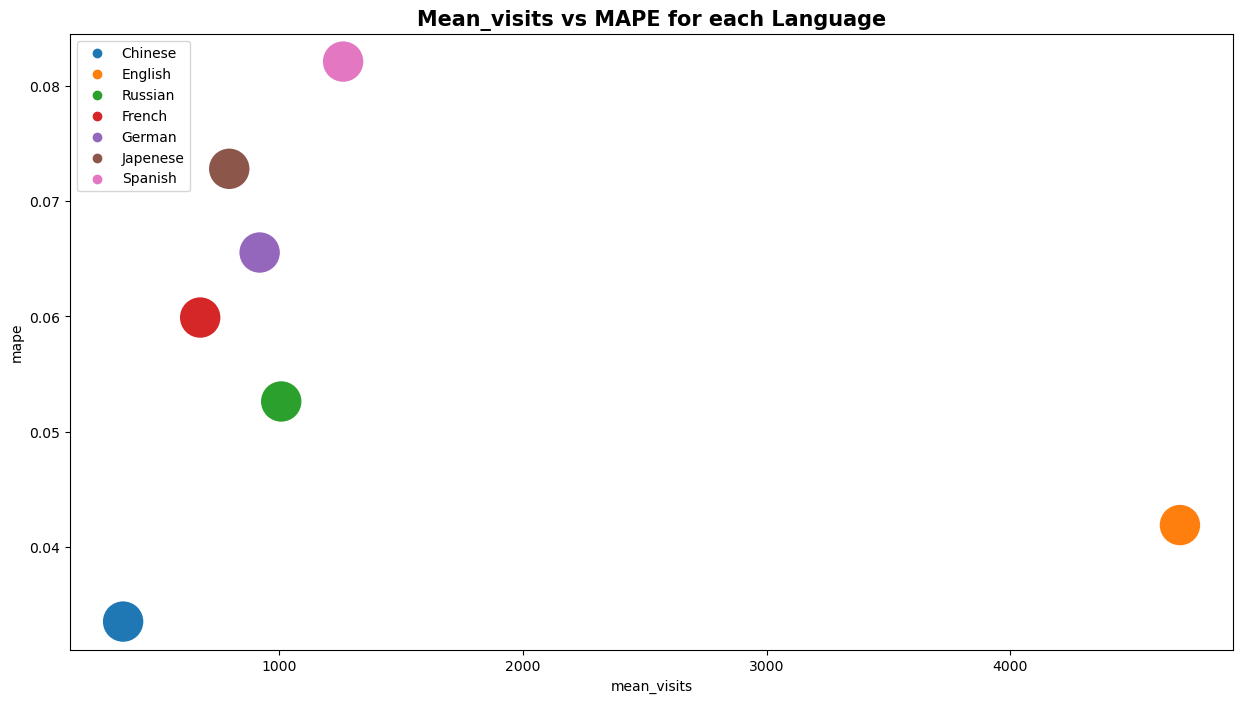

In [73]:
plt.figure(figsize = (15,8))
sns.scatterplot(x="mean_visits", y="mape", hue="language", data=df_visit_mape, s=1000 )
plt.legend(loc="upper left")
plt.title(f'Mean_visits vs MAPE for each Language', fontsize = 15, fontweight = 'bold')
plt.show()

**Recommendations based on MAPE & mean_visits:**

   - **English** language is a clear winner. Maximum advertisement should be done on English pages. Their MAPE is low & mean visits are high.
   - **Chinese** language has lowest number of visits. Advertisements on these pages should be avoided unless business has specific marketing strategy for Chinese populations.
   - **Russian** language pages have decent number of visits and low MAPE. If used properly, these pages can result in maximum conversion.
   - **Spanish** language has second highest number of visits but their MAPE is highest. There is a possibility advertisements on these pages won't reach the final people.
   - **French, German & Japenese** have medium level of visits & medium MAPE levels. Depending on target customers advertisements should be run on these pages.
   
# 10. Questionnaire
**1.	Defining the problem statements and where can this and modifications of this be used?**

- We are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. We are provided with the data of 145k wikipedia pages and daily view count for each of them. Our clients belong to different regions and need data on how their ads will perform on pages in different languages.

- By creating a proper forecasting model to predict the fluctuations of visits on pages, we can help the business team to optimise the marketing spend. If we can predict the days with higher visits properly, the business will run the ads for those specific days and still be able to reach wider audience with most optimized spend.

**2.	Write 3 inferences you made from the data visualizations.**

- There are **7 Languages** found based on data provided. **English has highest number of pages** followed by Japanese, German & French.
- There are **3 Access types** : **All-access(51.4%)**, mobile-web (24.9%) and desktop(23.6%).
- There are **2 Access-origins**: **all-agents (75.8%)** and spider (24.2%).

- **English** language is a clear winner. Maximum advertisement should be done on English pages. Their MAPE is low & mean visits are high.
- **Chinese** language has lowest number of visits. Advertisements on these pages should be avoided unless business has specific marketing strategy for Chinese populations.
- **Russian** language pages have decent number of visits and low MAPE. If used properly, these pages can result in maximum conversion.
- **Spanish** language has second highest number of visits but their MAPE is highest. There is a possibility advertisements on these pages won't reach the final people.
- **French, German & Japanese** have medium level of visits & medium MAPE levels. Depending on target customers advertisements should be run on these pages.

**3.	What does the decomposition of series do?**

- The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns.
- There are two principal types of decomposition : Additive & Multiplicative.
- In present business case we have used Additive Model for deconstructing the time series. The term additive means individual components (trend, seasonality, and residual) are added together as shown in equation below:

$y_{t}$ =  $T_{t}$ +  $S_{t}$  +  $R_{t}$

where 
- $y_{t}$ = actual value in time series
- $T_{t}$ = trend in time series
- $S_{t}$ = seasonality in time series
- $R_{t}$ = residuals of time series

**4.	What level of differencing gave you a stationary series?**
- A non-stationary time series can be converted to a stationary time series through a technique called differencing. Differencing series is the change between consecutive data points in the series.

$y'_{t}$ =  $y_{t}$ -  $y_{t-1}$ 

This is called first order differencing.

- In some cases, just differencing once will still yield a nonstationary time series. In that case a second order differencing is required.

- Seasonal differencing is the change between the same period in two different seasons. Assume a season has period, m

$y'_{t}$ =  $y_{t}$ -  $y_{t-m}$

- Once the time series becomes stationary, no differencing is required.

**5.	Difference between arima, sarima & sarimax.**

- The **ARIMA model** is an ARMA model yet with a pre-processing step included in the model that we represent using I(d). I(d) is the difference order, which is the number of transformations needed to make the data stationary. So, an ARIMA model is simply an ARMA model on the differenced time series.


- In **SARIMA models** there is an additional set of autoregressive and moving average components. The additional lags are offset by the frequency of seasonality (ex. 12 — monthly, 24 — hourly). SARIMA models allow for differencing data by seasonal frequency, yet also by non-seasonal differencing.


- **SARIMAX model** takes into account exogenous variables, or in other words, use external data in our forecast. Some real-world examples of exogenous variables include gold price, oil price, outdoor temperature, exchange rate.


**6.	Compare the number of views in different languages**
- Mean number of views (Popularity sequence) of various languages have the following : 

**English > Spanish > Russian > German > Japanese > French > Chinese**

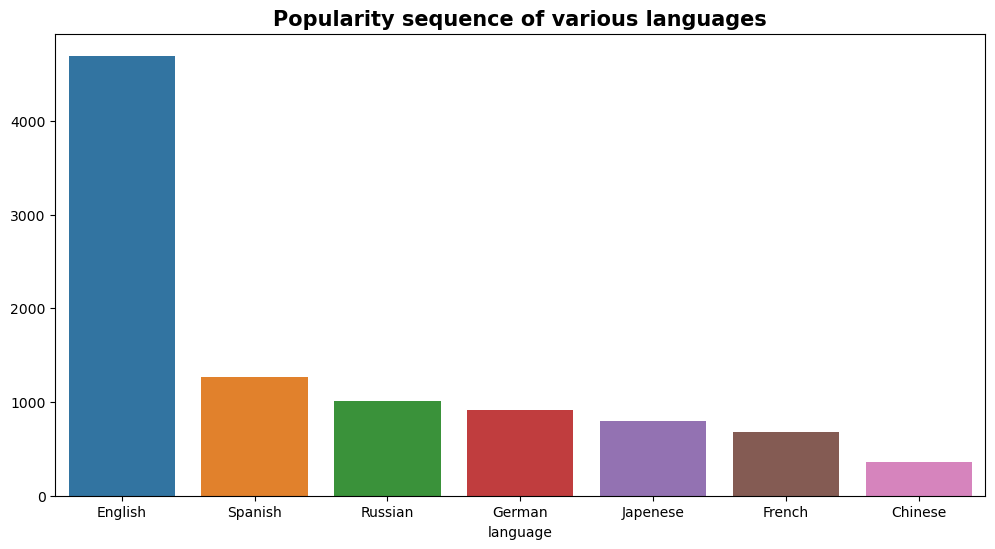

In [74]:
x = data_language.mean().sort_values(ascending = False).index
y = data_language.mean().sort_values(ascending = False).values

plt.figure(figsize=(12, 6))
sns.barplot(x=x,y=y)
plt.title(f'Popularity sequence of various languages', fontsize = 15, fontweight = 'bold')
plt.show()

**7.	What other methods other than grid search would be suitable to get the model for all languages?**
- **Deep understanding of Domain / Business or relevant experience** in the same field can be good starting point for estimating the parameters of the model intuitively.
- Second level estimation can come from **ACF & PACF plots** of the time series. We can take following steps for estimation of p, q, d:

    - Test for stationarity using the augmented dickey fuller test.
    - If the time series is stationary try to fit the ARMA model, and if the time series is non-stationary then seek the **value of d.**
    - If the data is getting stationary then draw the autocorrelation and partial autocorrelation graph of the data.
    - Draw a partial autocorrelation graph(ACF) of the data. This will help us in finding the value of p because the **cut-off point to the PACF is p**. 
    - Draw an autocorrelation graph(ACF) of the data. This will help us in finding the value of q because the **cut-off point to the ACF is q**.
